In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
import uproot as ur
import root_numpy as rtnp
import ROOT as rt
import sys, yaml, os
sys.path.append('../lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from progressBar import ProgressBar
from gridVarQ2Plot import label_dic
from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = ' '*7+'Internal Simulation'

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [3]:
category = 'low'
card_name = 'v8'+category+'_CLN'
# processToPlot = 'tot'
processToPlot = 'tau'

In [4]:
histosLoc = '../data/_root/histos4combine/{}_{}_q2bin{}.root'
fileH = {}
for var in ['M2_miss', 'Est_mu']:
    for iq2 in [2,3]:
        n = var+str(iq2)
        fileH[n] = rt.TFile.Open(histosLoc.format(card_name, var, iq2), 'READ')

In [5]:
outdir = '../Combine/results/'+card_name + '/fig/shapeUncertainties_'+processToPlot
webDir = '/storage/user/ocerri/public_html/BPH_RDst/Combine/' + card_name + '/shapeUncertainties_'+processToPlot
for d in [outdir, webDir]:
    if os.path.isdir(d):
        os.system('rm -rf '+d)
    os.system('mkdir -p '+d)
    if 'public_html' in d:
        os.system('cp {d}/../index.php {d}/'.format(d=d))

In [6]:
q2binning = [0, 3.5, 6, 9.4, 12]
CMS_lumi.integrated_lumi = {'low':6.4, 'mid':20.7, 'high':26.4}[category] #fb^-1
inj_RDst = 0.295

In [7]:
keysList = []
for k in fileH.values()[0].GetListOfKeys():
    keysList.append(k.GetTitle())
keysList = np.sort(keysList)
procList = np.sort([k for k in keysList if not '__' in k and not 'Data' in k and not 'Total' in k])
if not processToPlot == 'tot':
    procList = [processToPlot]

In [8]:
procList

['tau']

In [9]:
hCentral = {}

for kk ,f in fileH.iteritems():
    hCentral[kk] = None
    for k in procList:
        hAux = f.Get(k)
        if hCentral[kk] is None:
            hCentral[kk] = hAux.Clone('Cent.')
        else:
            c = inj_RDst if k == 'tau' else 1
            hCentral[kk].Add(hAux, c)
            
    hCentral[kk].SetTitle('Central')
    hCentral[kk].GetYaxis().SetTitle('Events')
    if 'M2_miss' in kk:
        title = 'M^{2}_{miss} [GeV^{2}]'
    elif 'Est_mu' in kk:
        title = 'E*_{#mu} [GeV]'
    hCentral[kk].GetXaxis().SetTitle(title)
    hCentral[kk].GetYaxis().SetRangeUser(0, 1.3*hCentral[kk].GetMaximum())

In [10]:
def getVarHistos(tag):
    hOut = {}

    for kk ,f in fileH.iteritems():
        hOut[kk] = None
        for p in procList:
            k = p+'__'+tag
            if not k in keysList:
                k = p

            hAux = f.Get(k)
            if hOut[kk] is None:
                hOut[kk] = hAux.Clone(tag)
            else:
                c = inj_RDst if 'tau' in k else 1
                hOut[kk].Add(hAux, c)
        hOut[kk].SetTitle(tag)
    return hOut

In [11]:
variationsList = list(set([k[k.find('__')+2:] for k in keysList if '__' in k]))
variationsList = np.sort([k[:-2] for k in variationsList if k[-2:] == 'Up'])

In [12]:
print 'Total variations', len(variationsList)
print variationsList

Total variations 35
['B0pTLow_lam1' 'B0pTLow_lam2' 'B0pTLow_lam3' 'B0pTLow_lam4' 'B2DstCLNR0'
 'B2DstCLNeig1' 'B2DstCLNeig2' 'B2DstCLNeig3' 'BpPtLow_lam1'
 'BpPtLow_lam2' 'BpPtLow_lam3' 'BpPtLow_lam4' 'BrB02DstD0Kp'
 'BrB02DstD0Kstp' 'BrB02DstDpK0' 'BrB02DstDpKst0' 'BrB02DstDs'
 'BrB02DstDs0st' 'BrB02DstDsst' 'BrB02DstDst0Kp' 'BrB02DstDst0Kstp'
 'BrB02DstDstpK0' 'BrB02DstDstpKst0' 'D2420_10Width' 'D2460_1StWidth'
 'DstPiPiWidth' 'fDststWide' 'softTrkEff_s' 'softTrkEff_w'
 'trgMu7_IP4SF_pt4' 'trgMu7_IP4SF_pt5' 'trgMu7_IP4SF_pt6'
 'trgMu7_IP4SF_pt7' 'trgMu7_IP4SF_pt8' 'trgMu7_IP4SF_pt9']


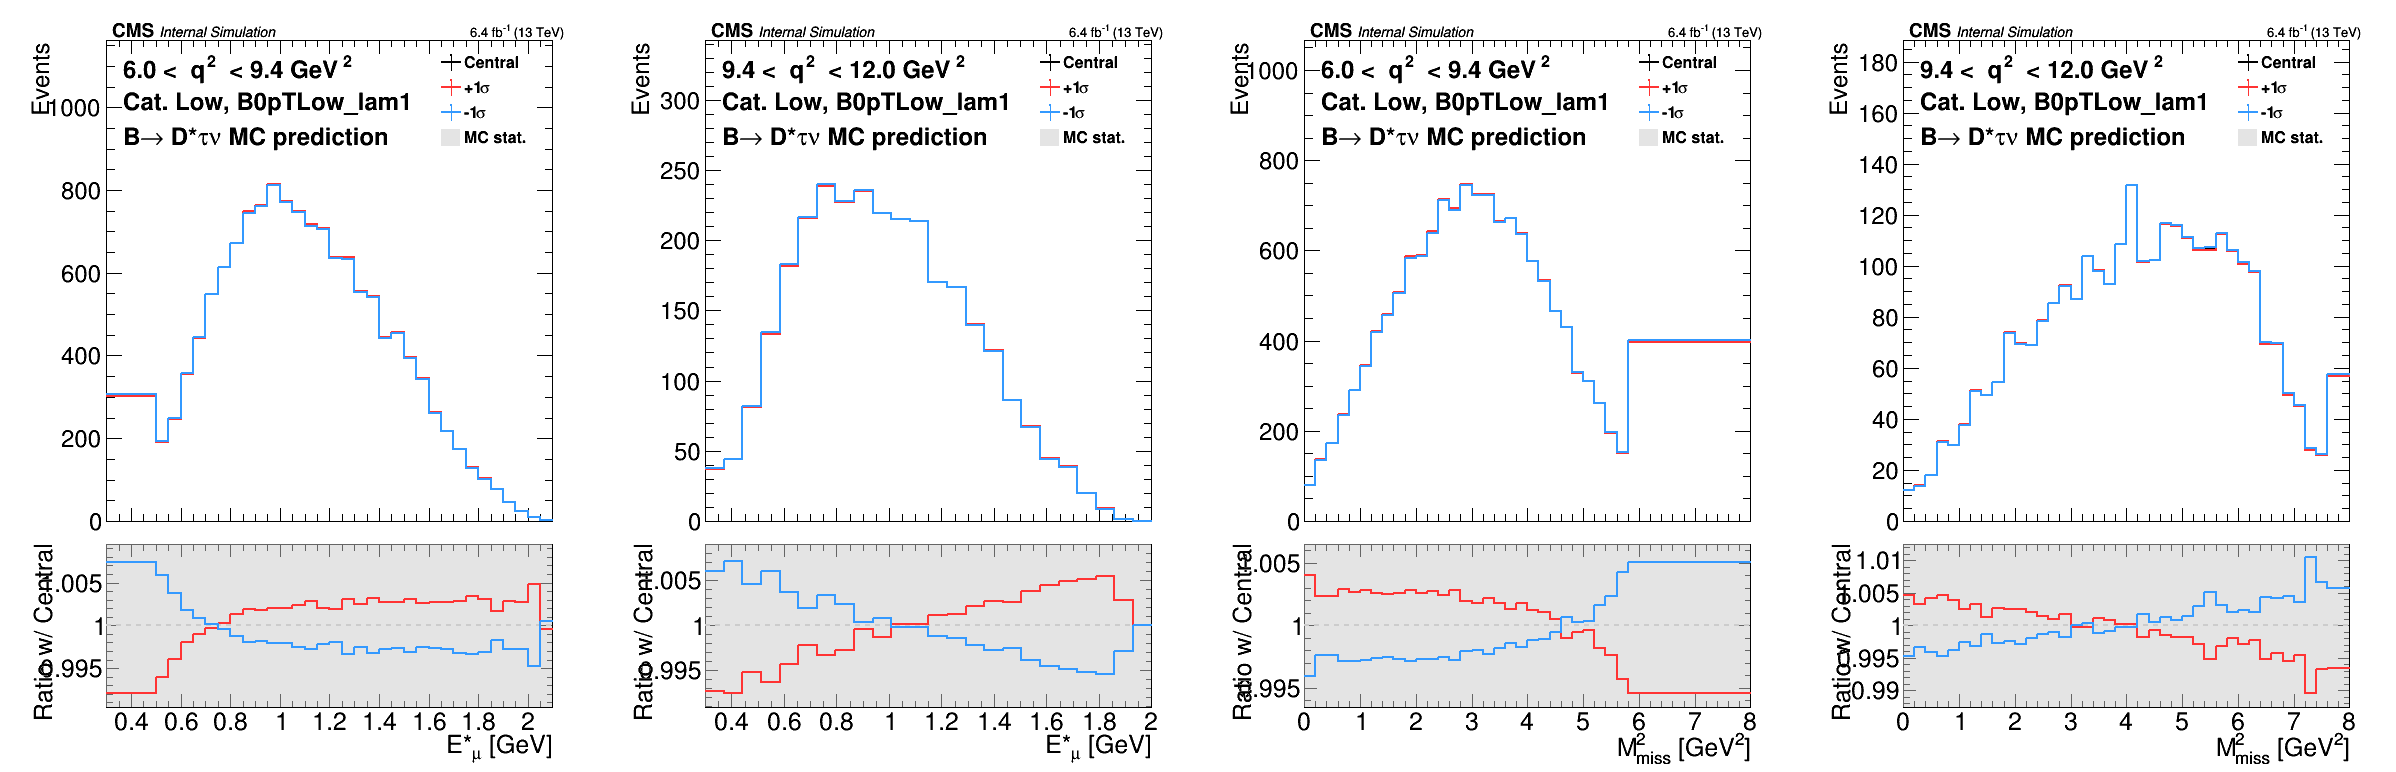

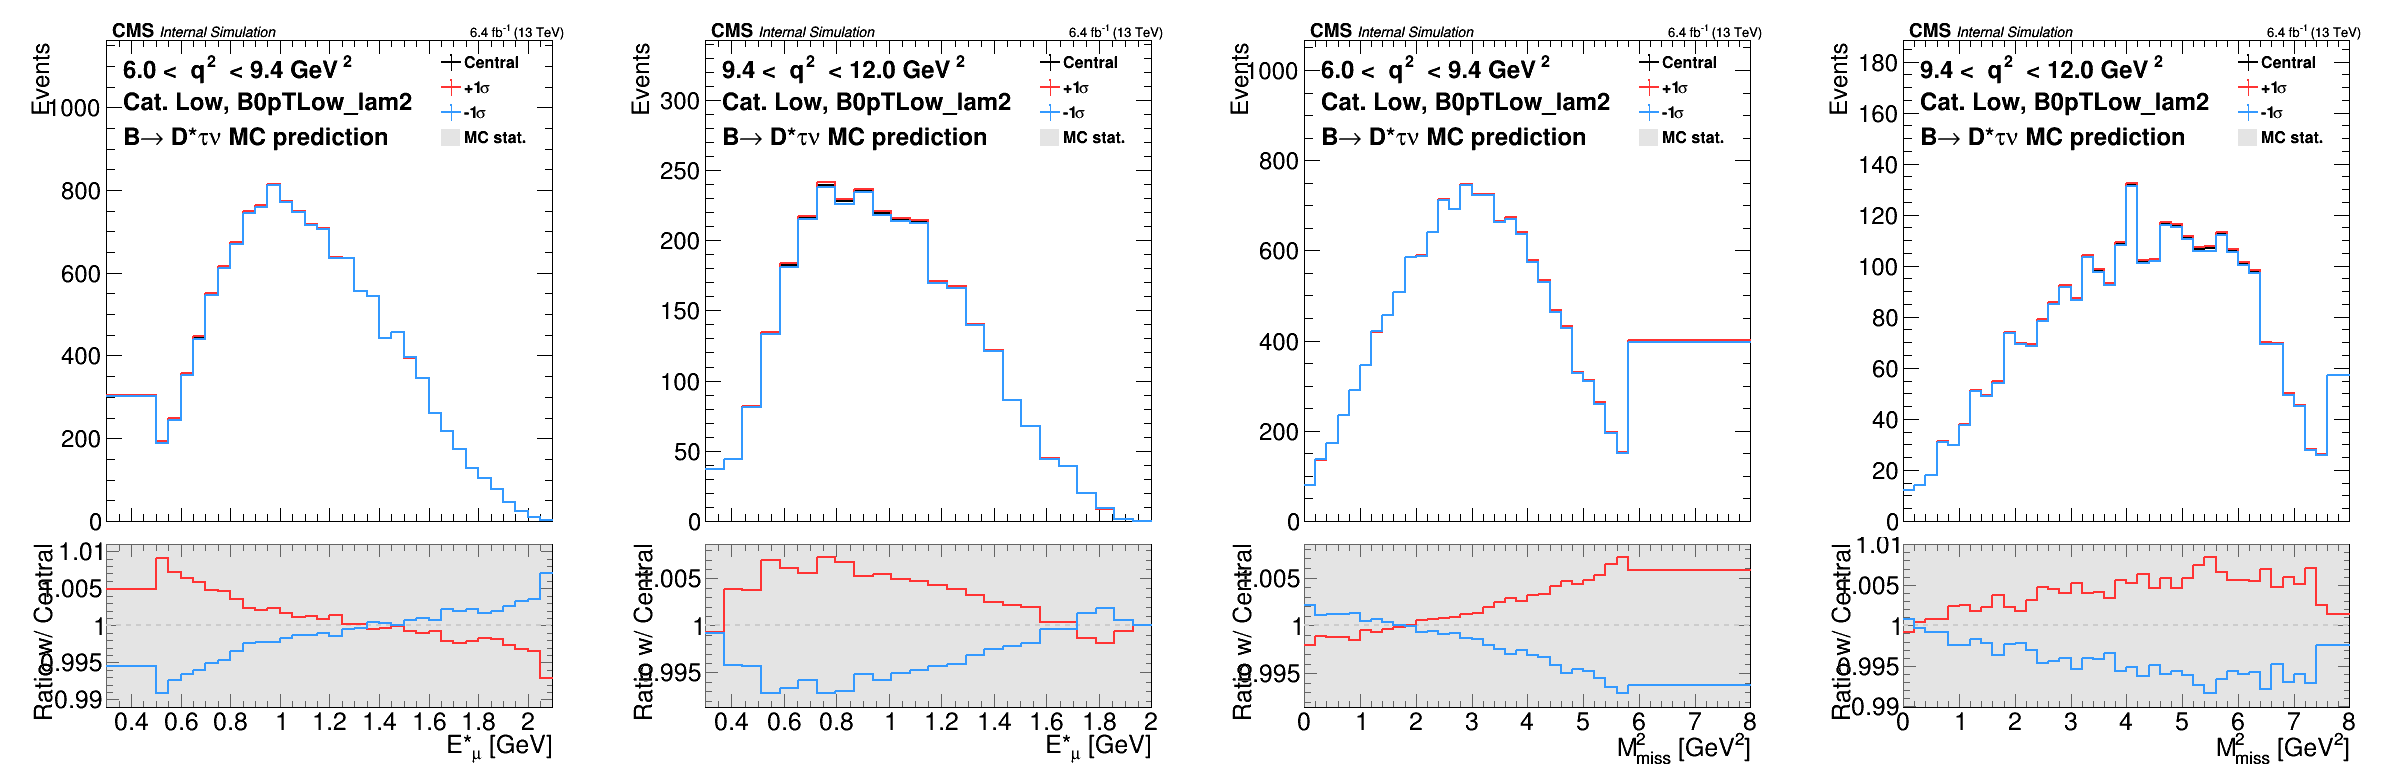

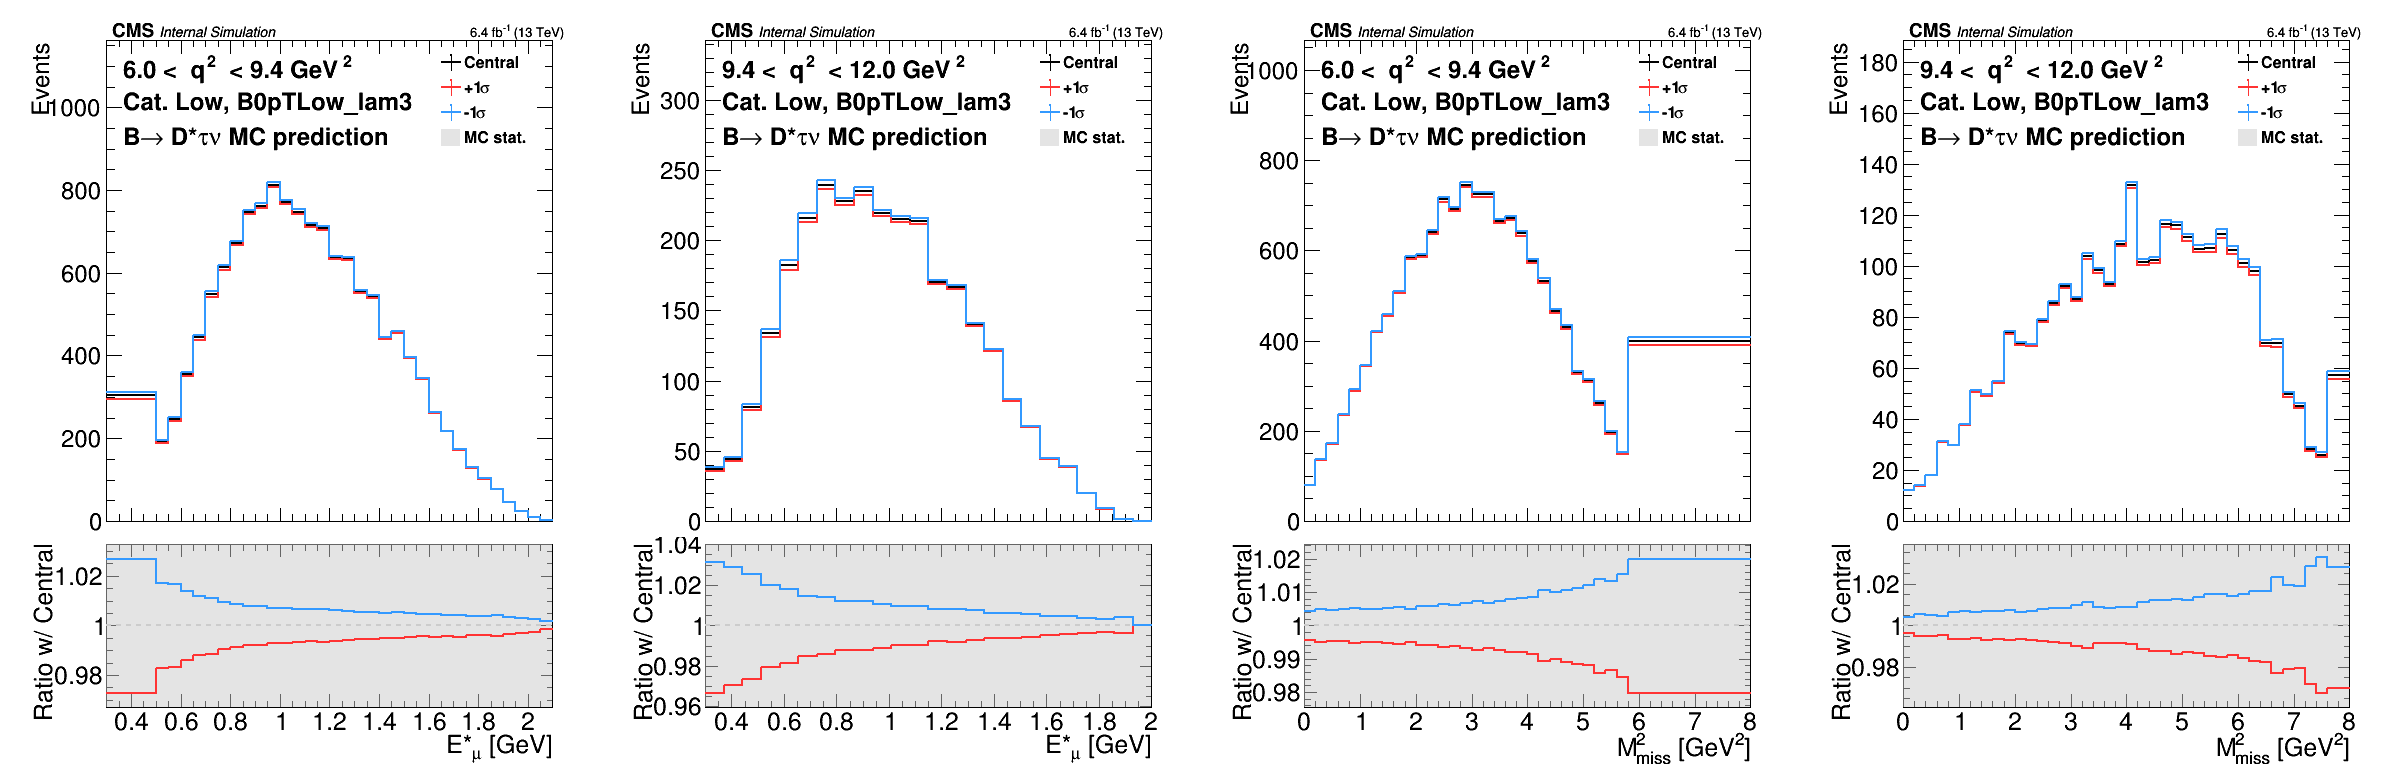

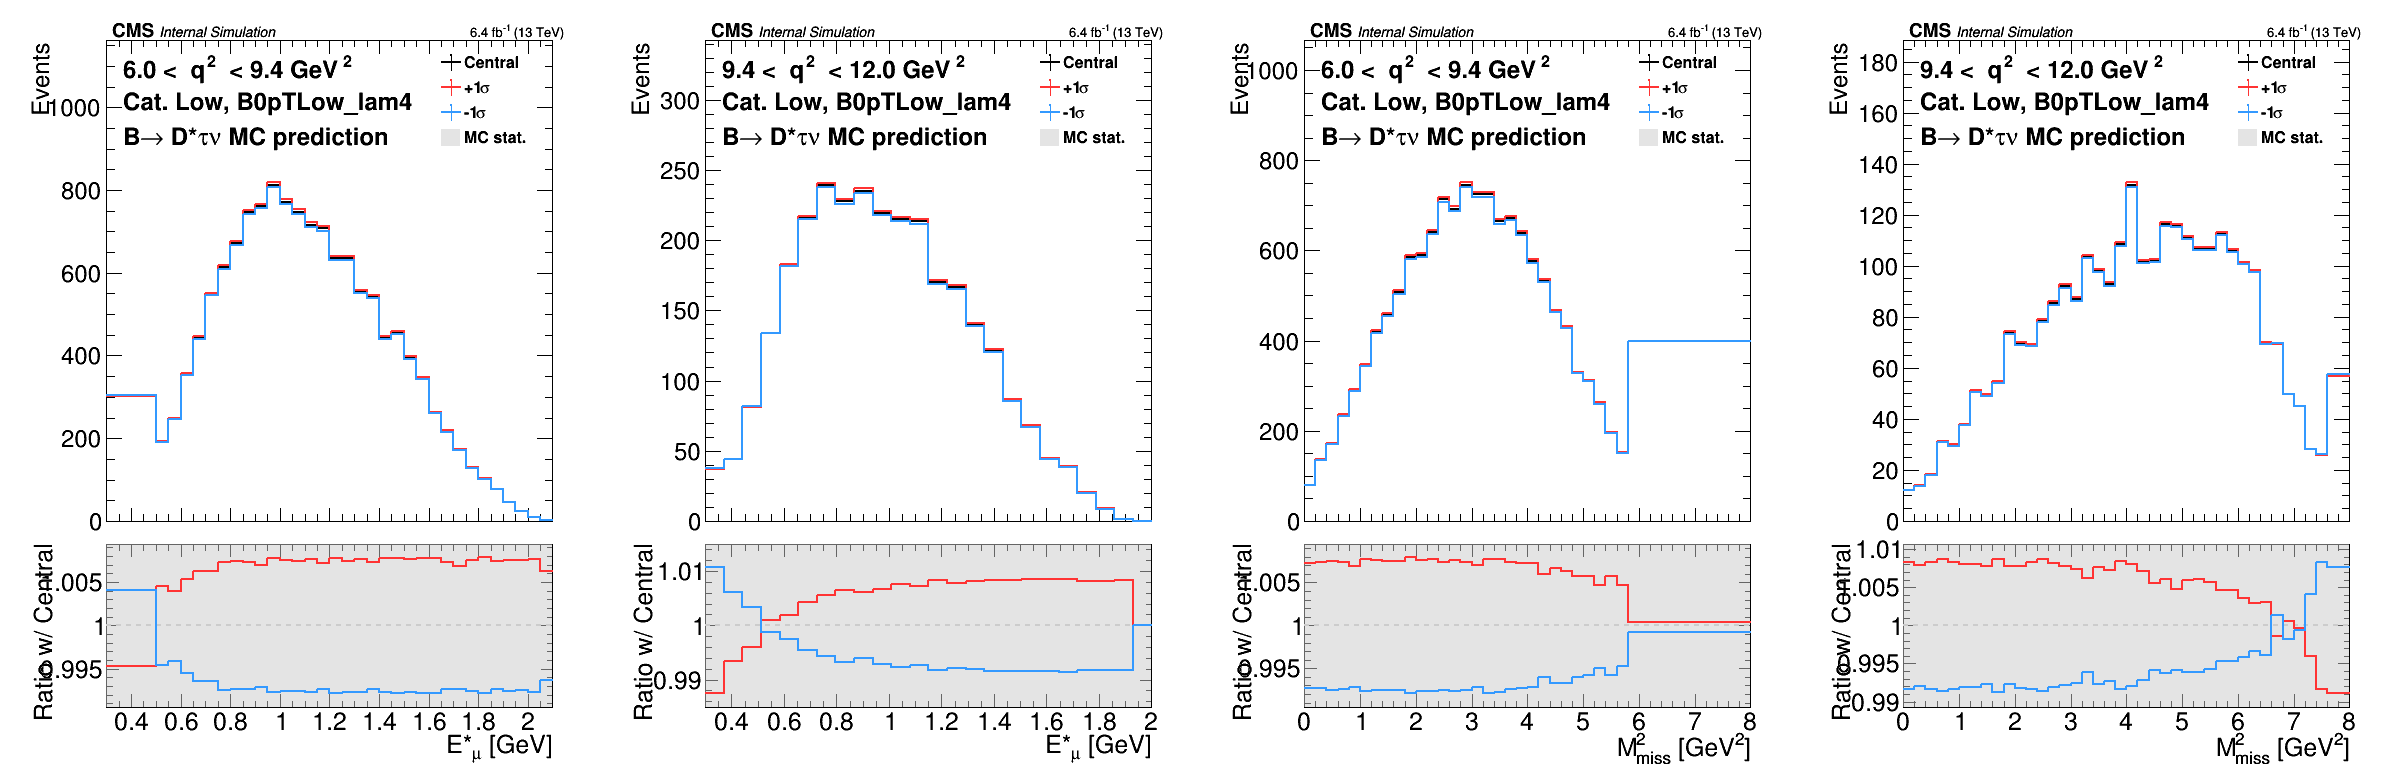

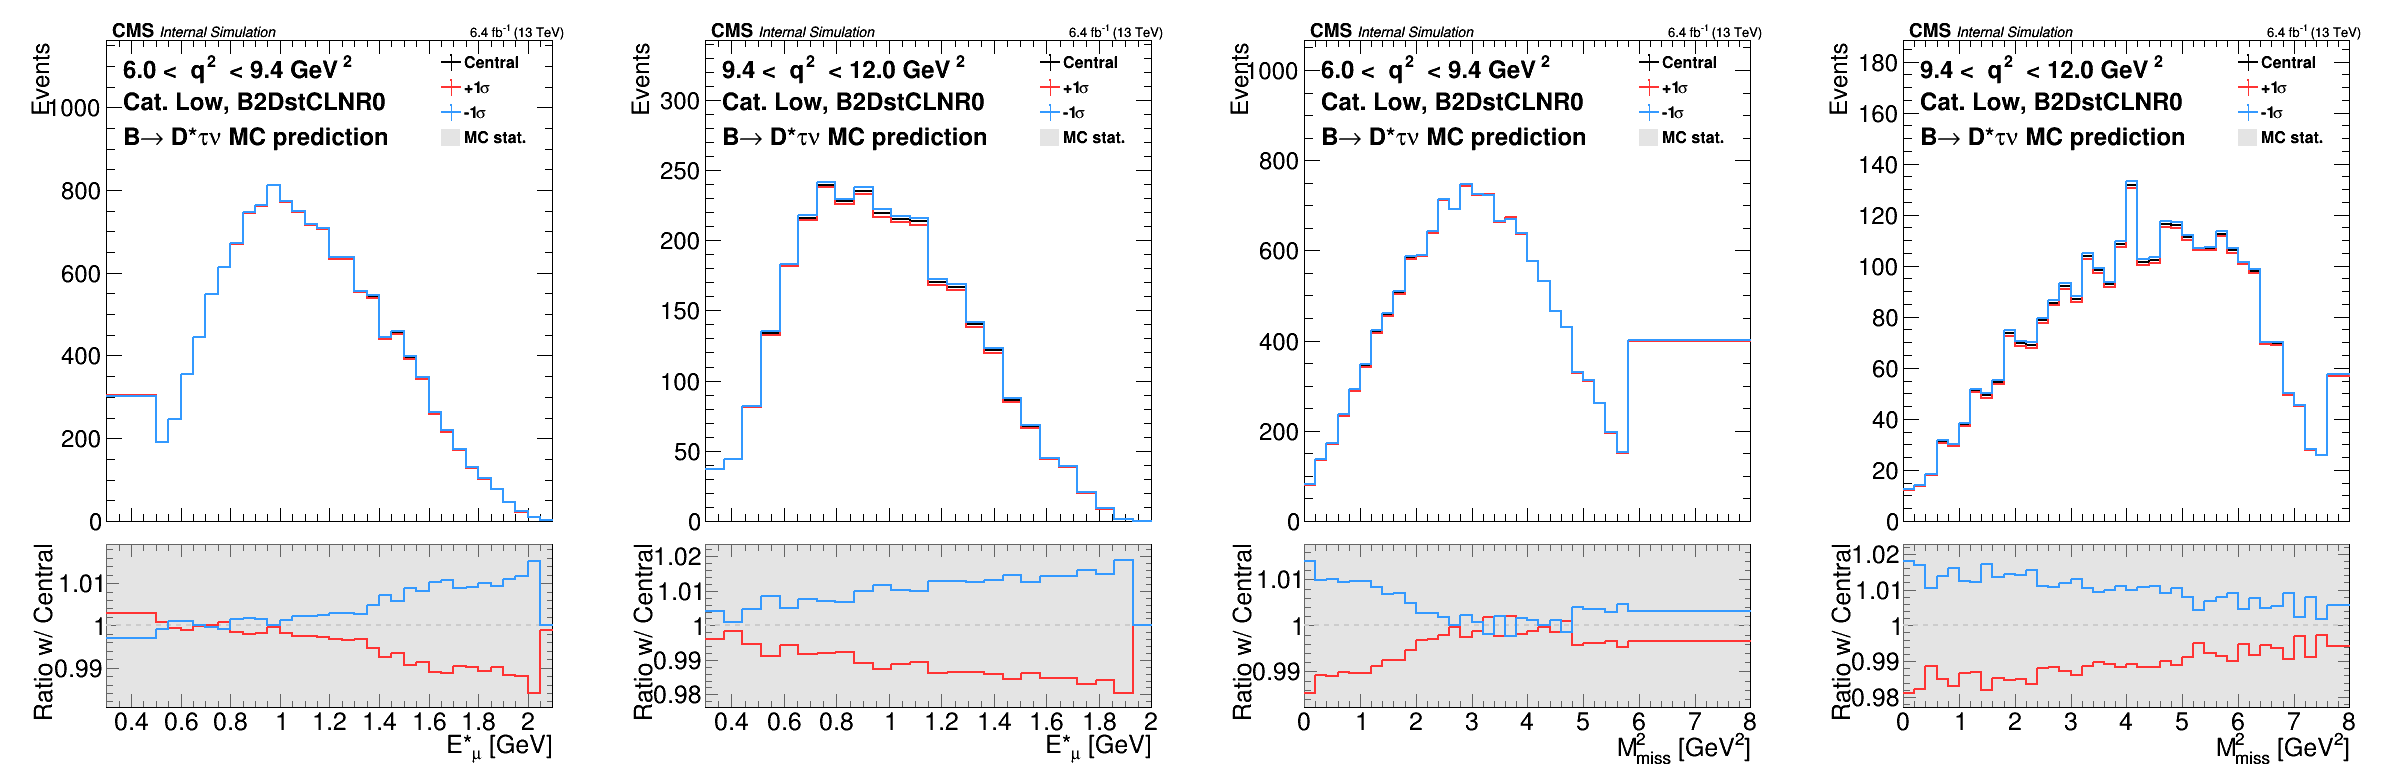

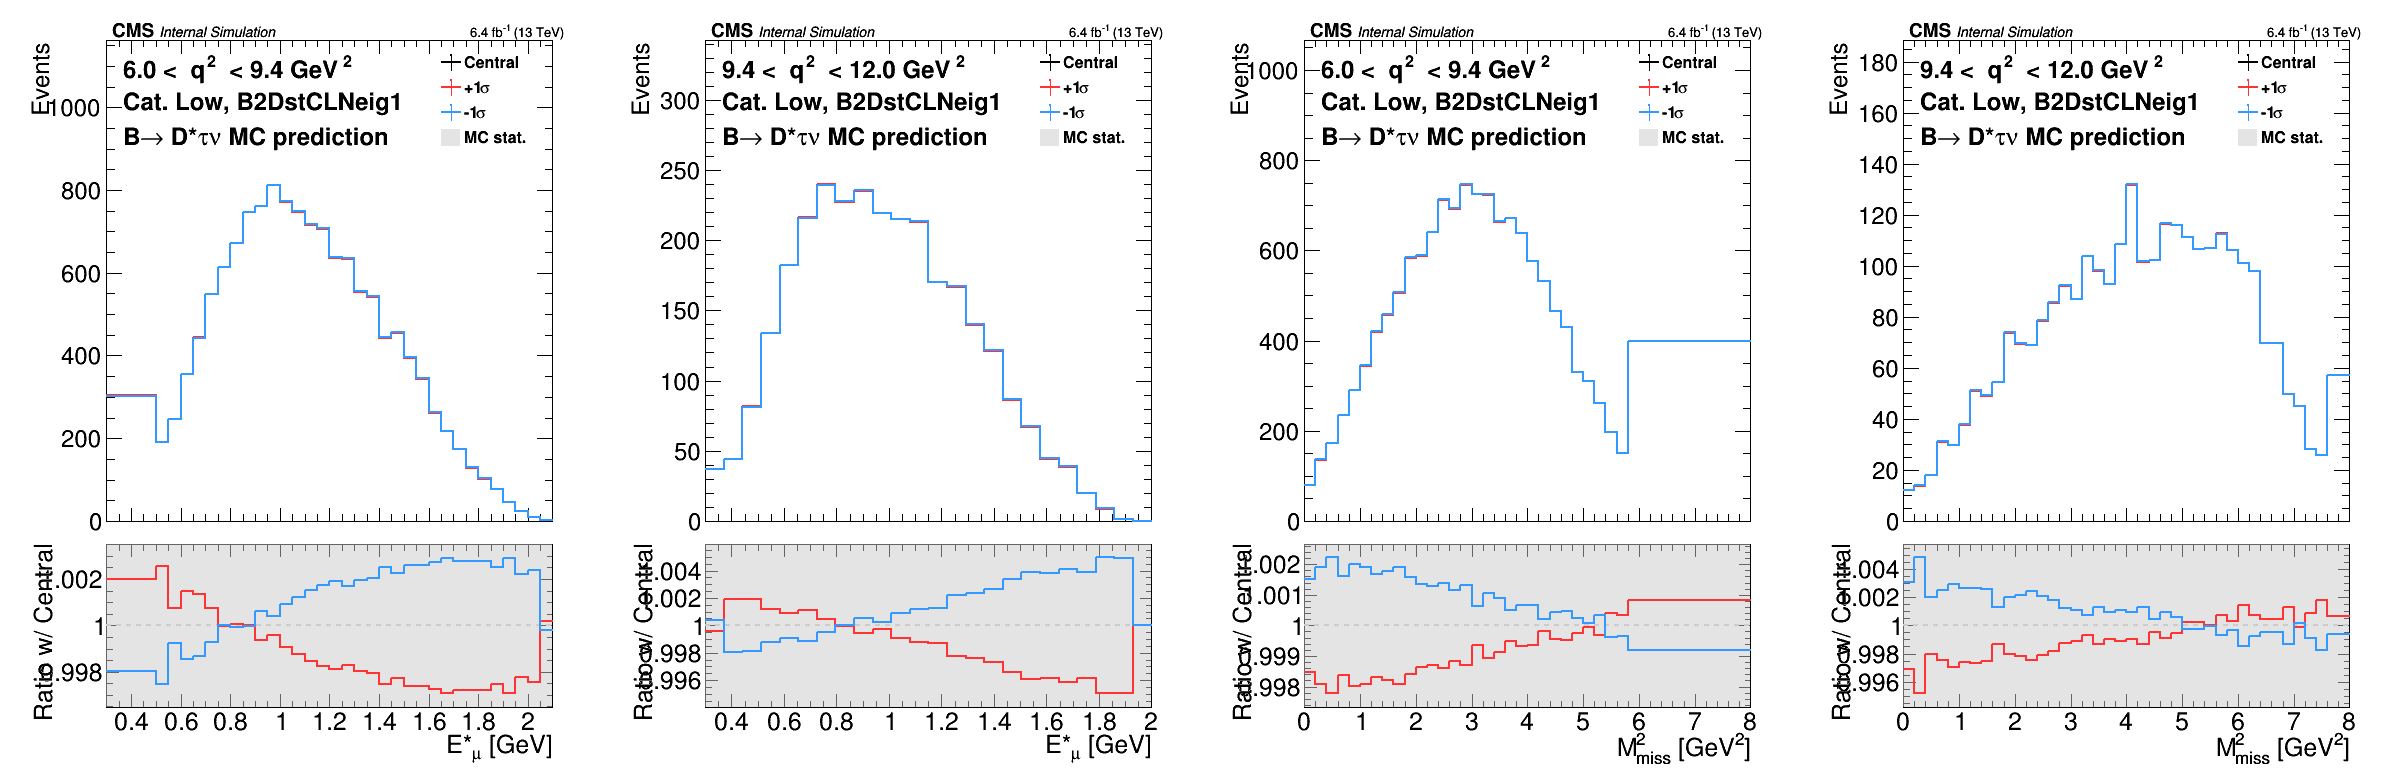

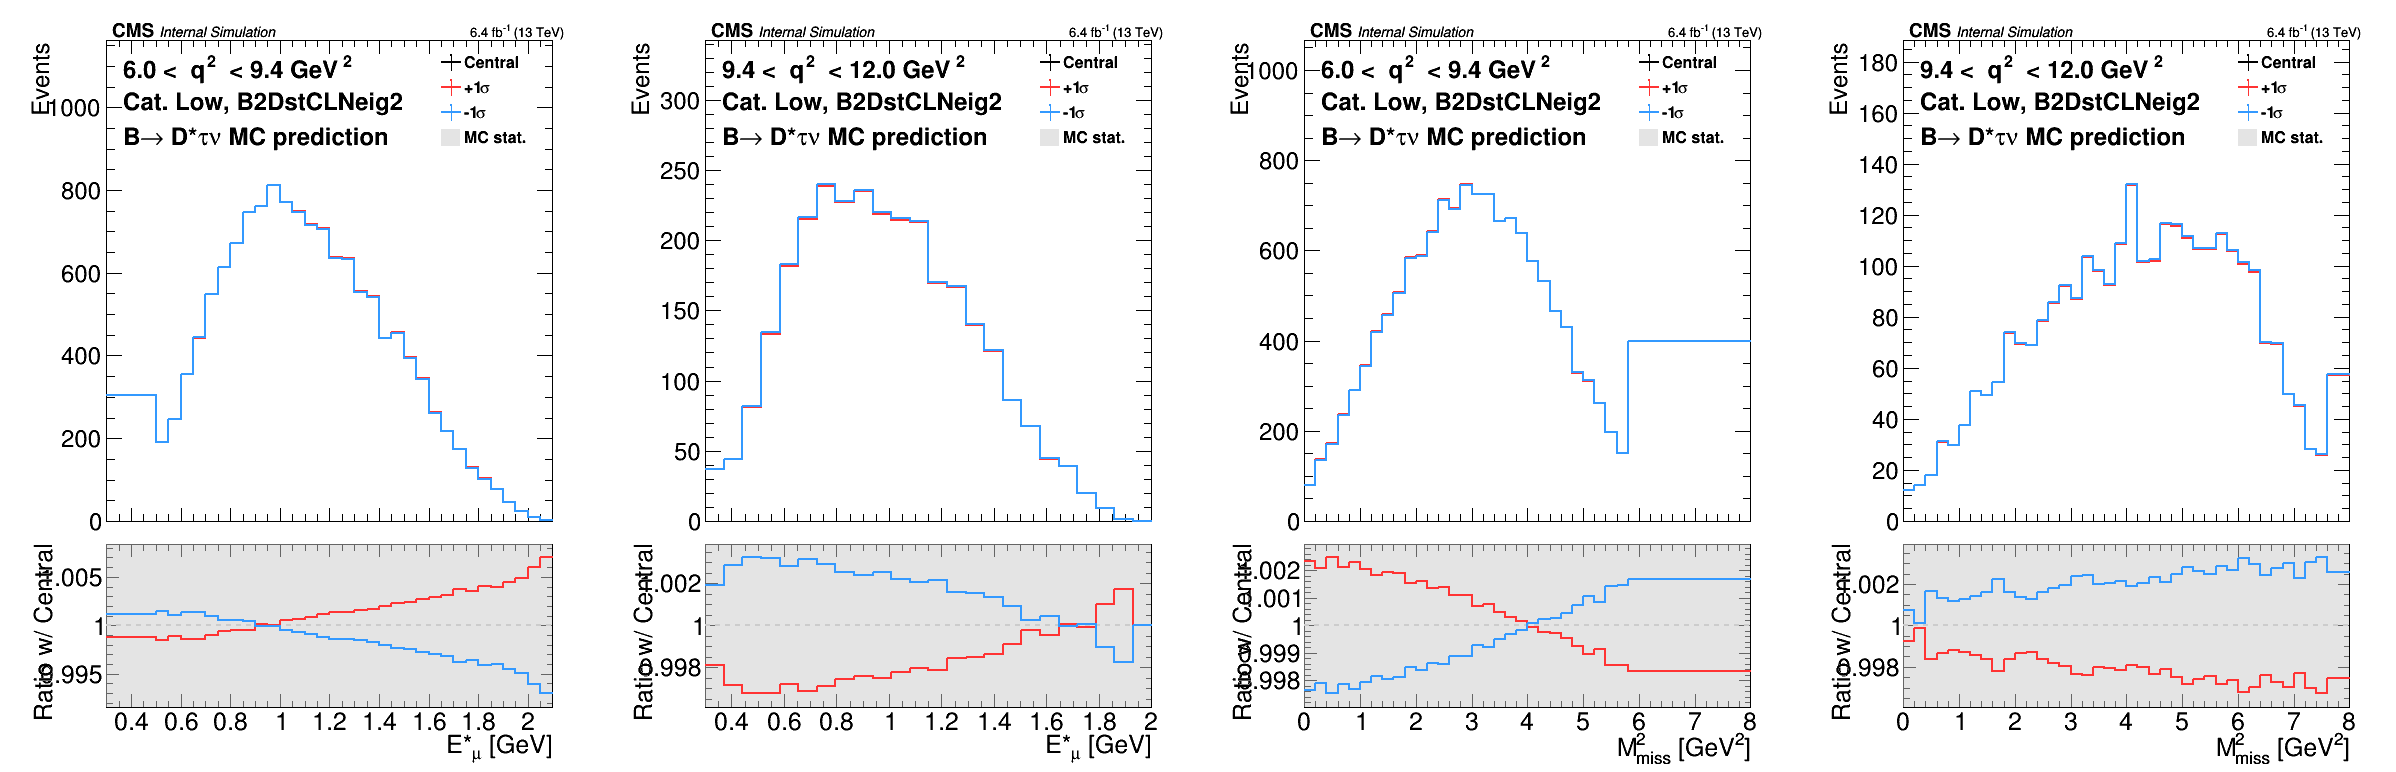

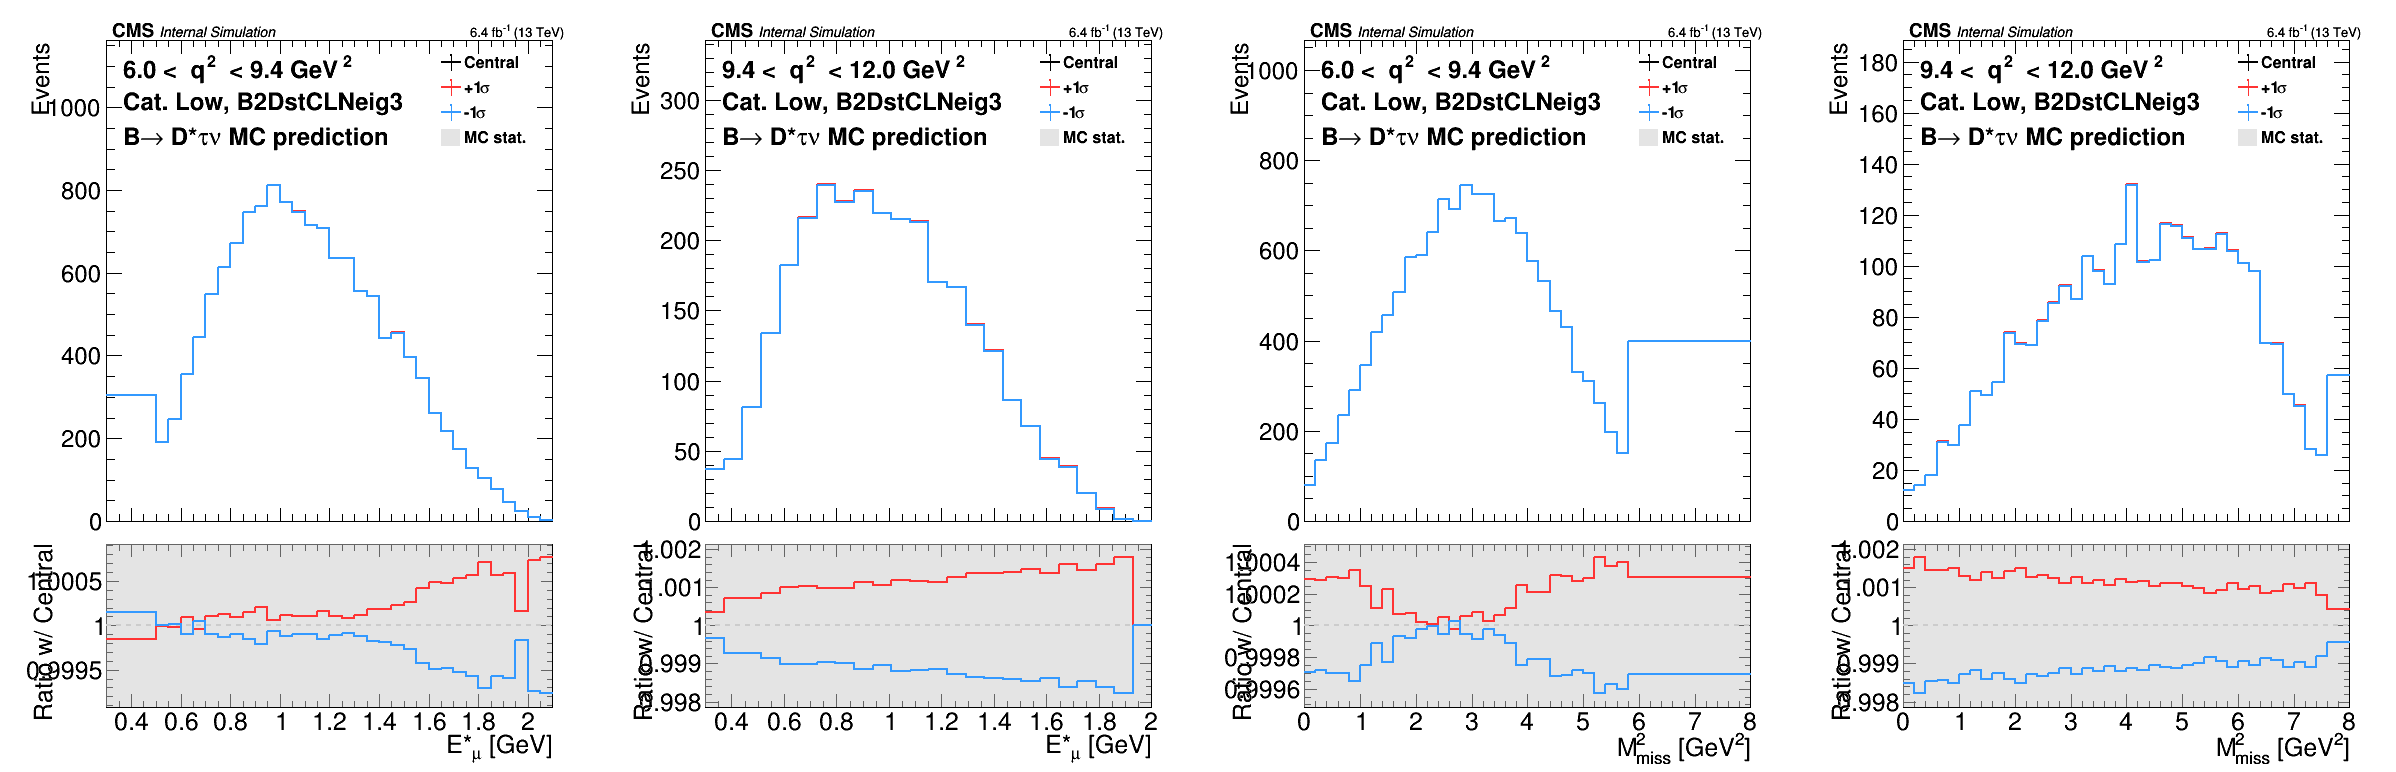

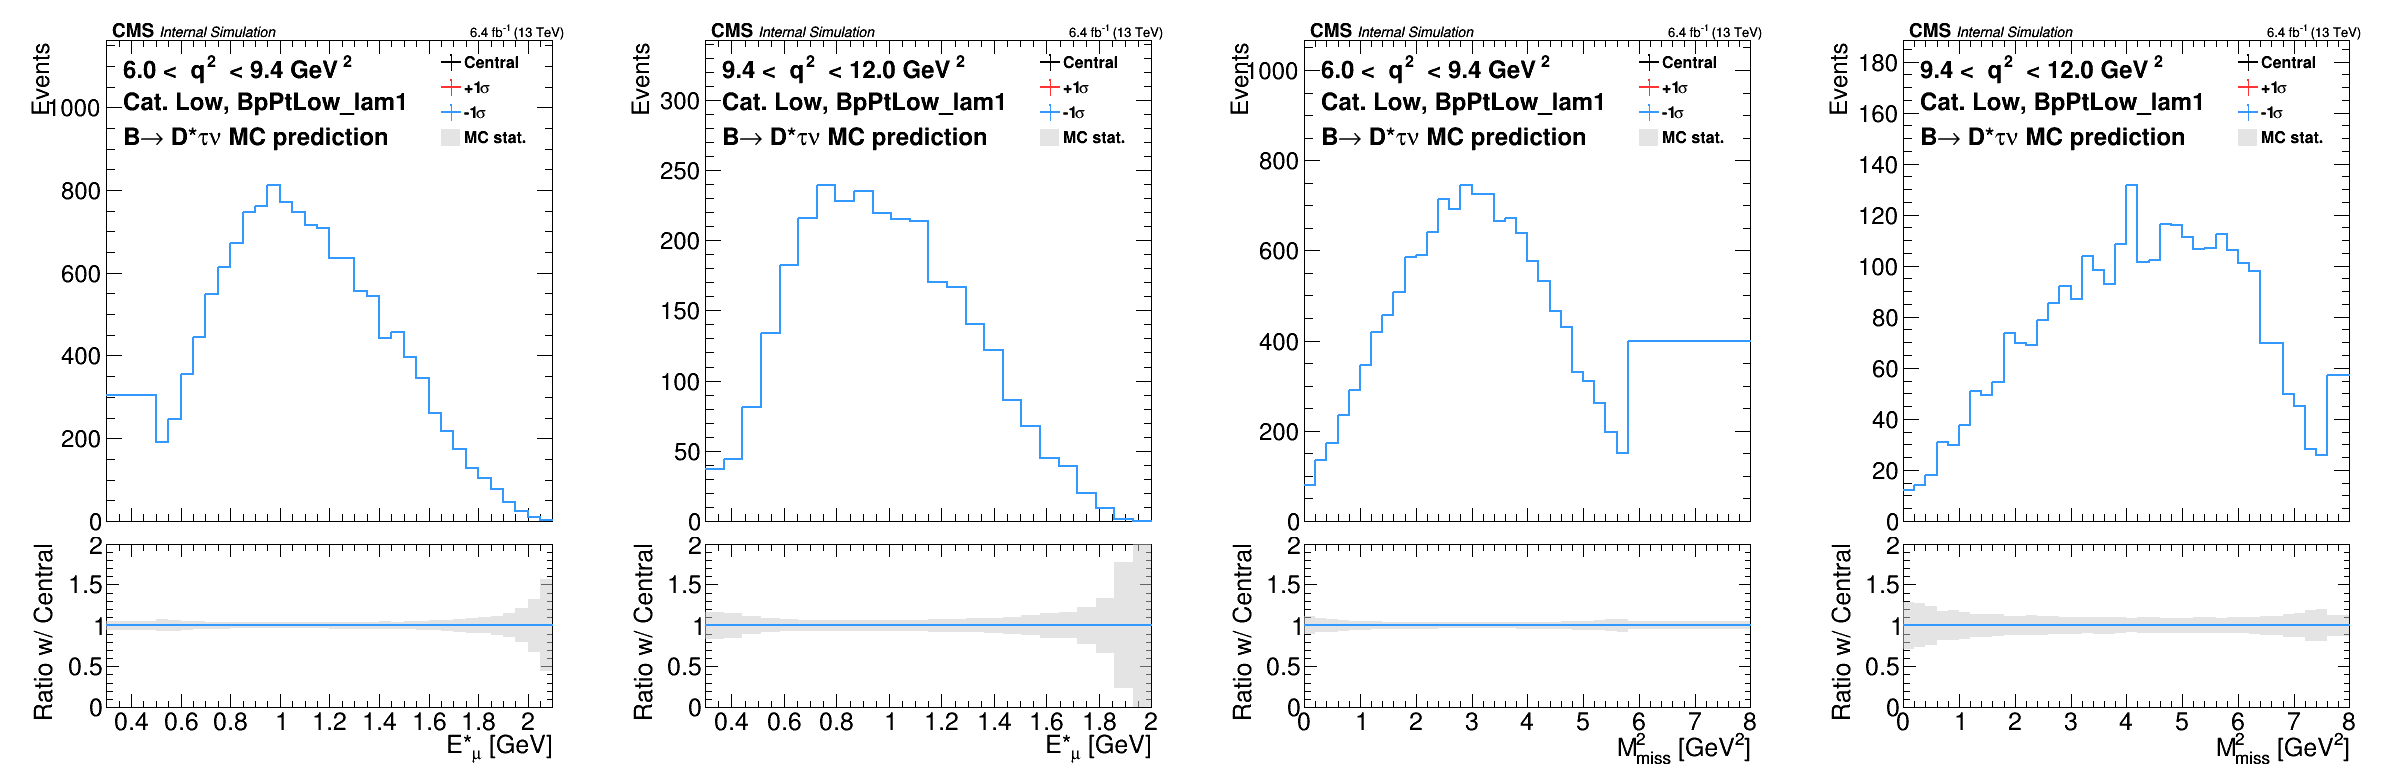

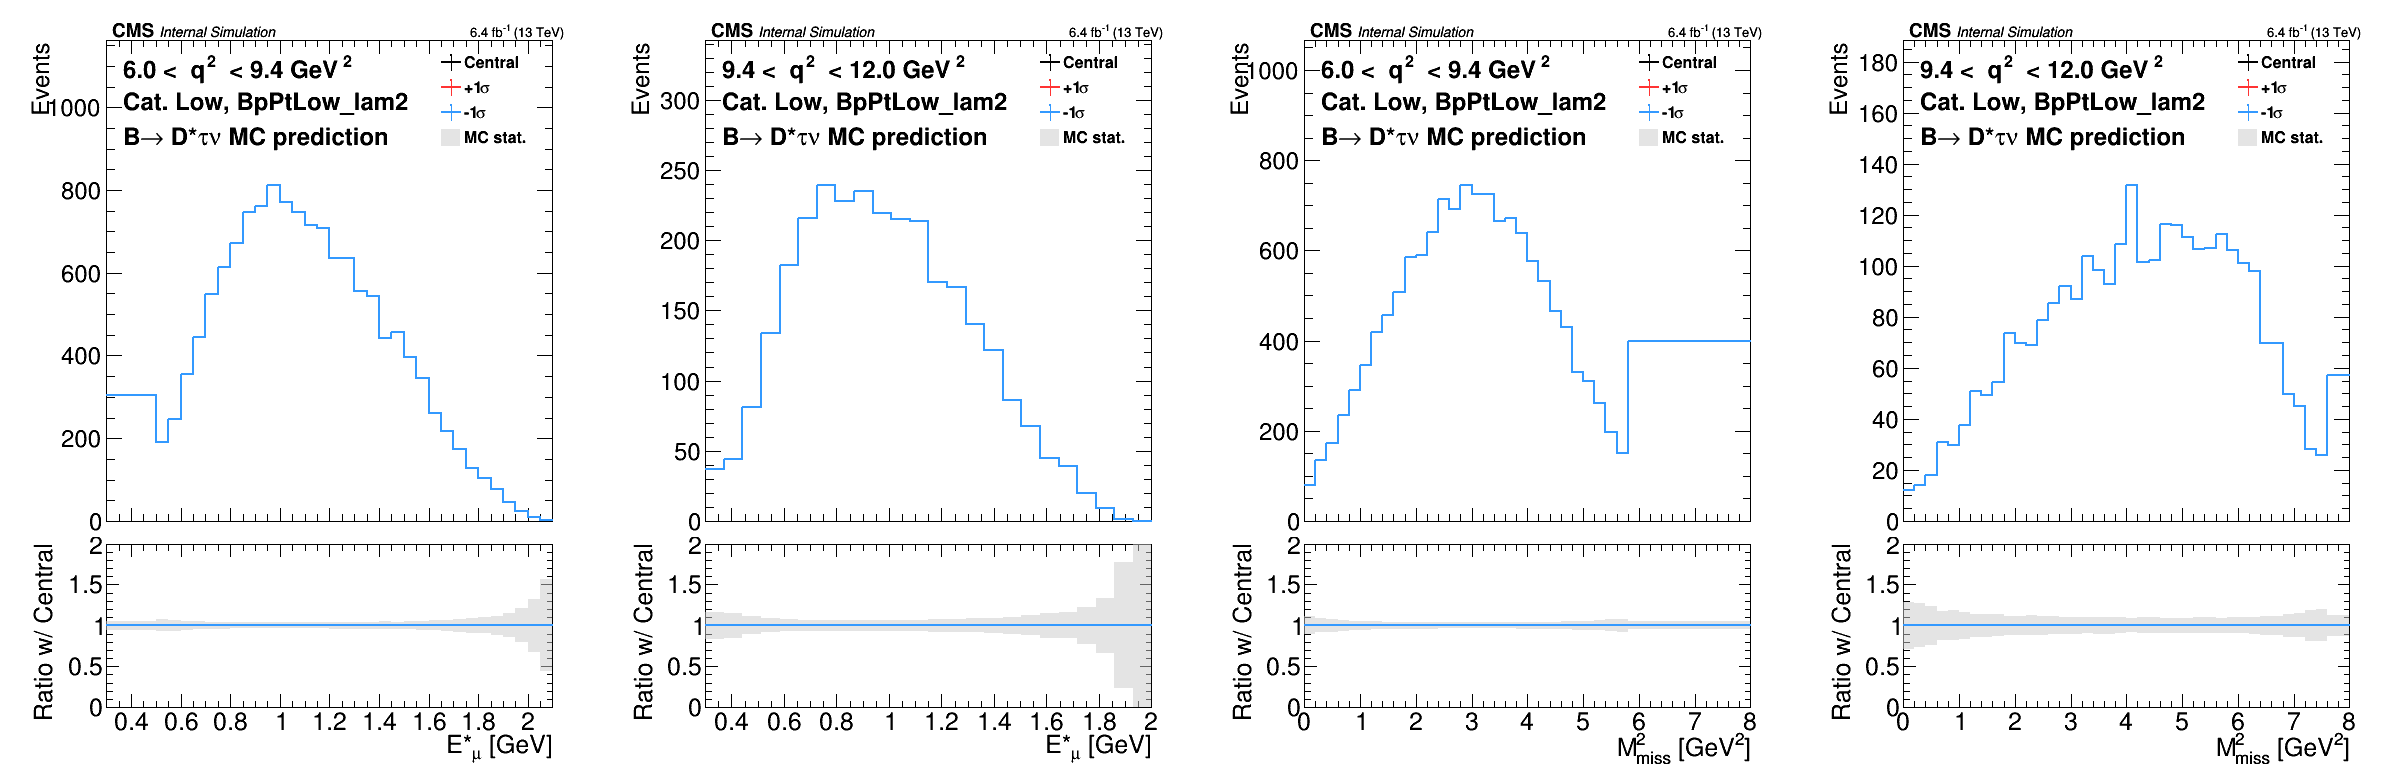

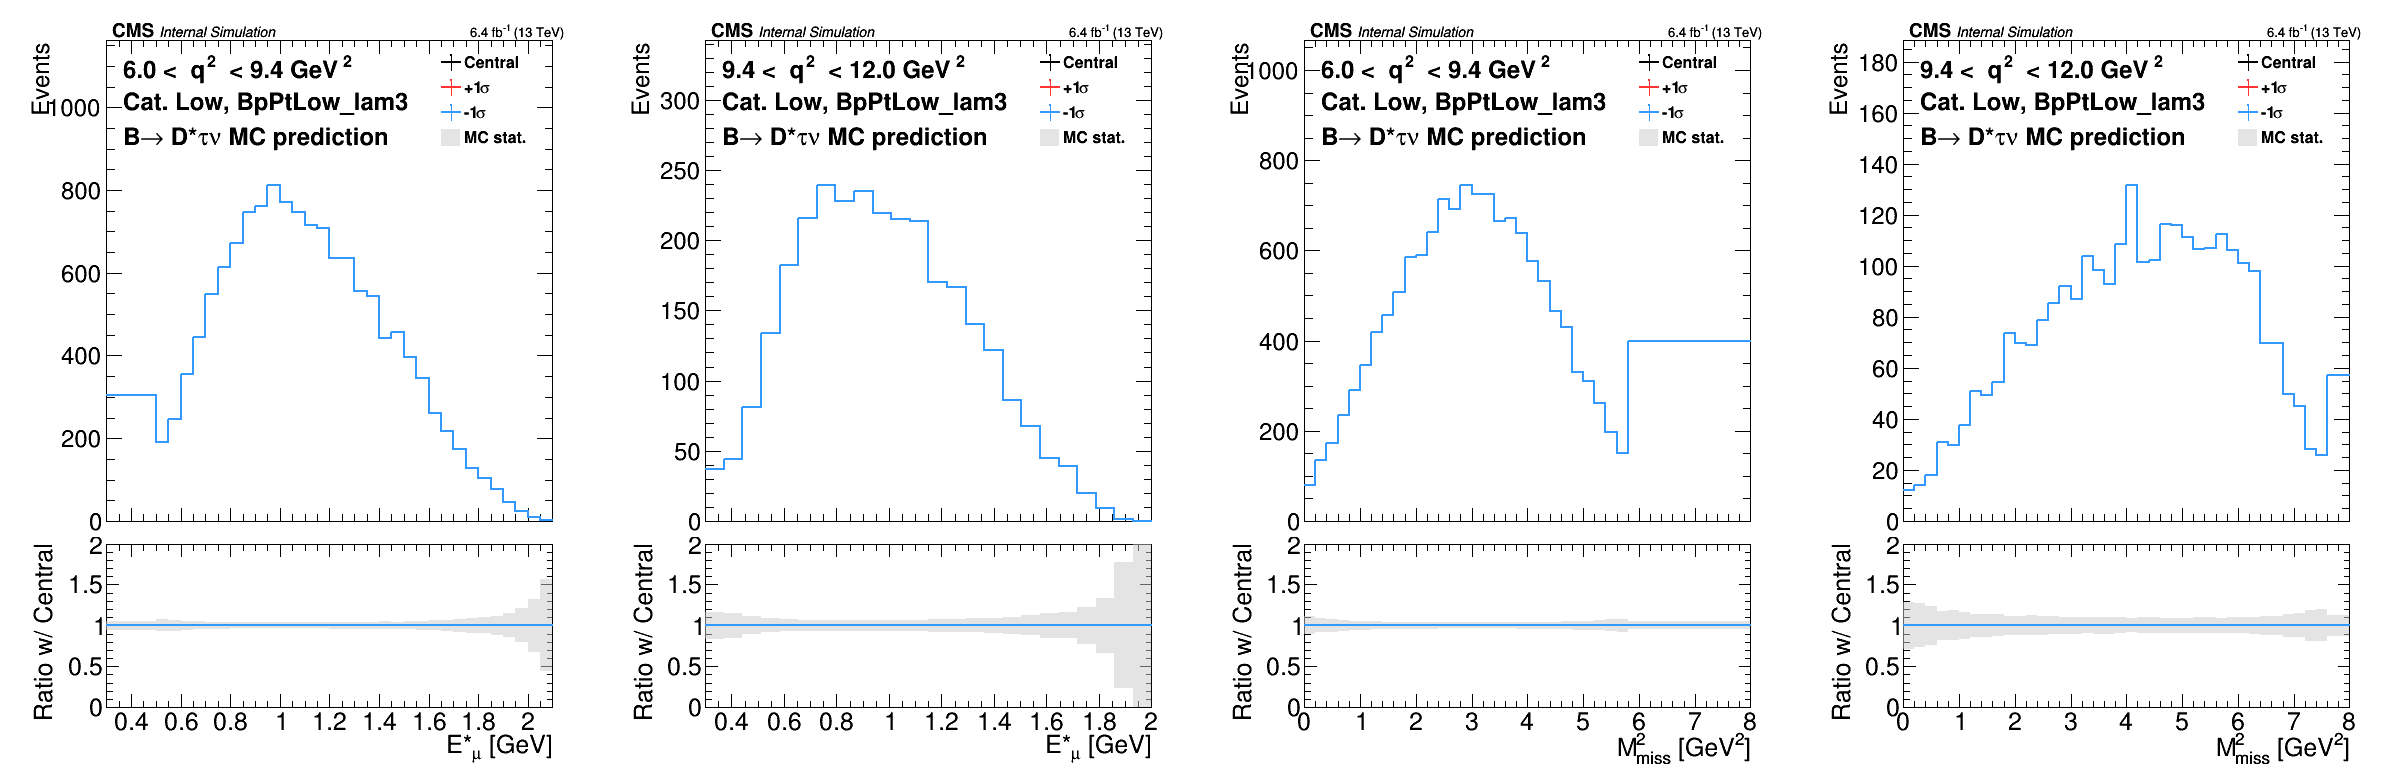

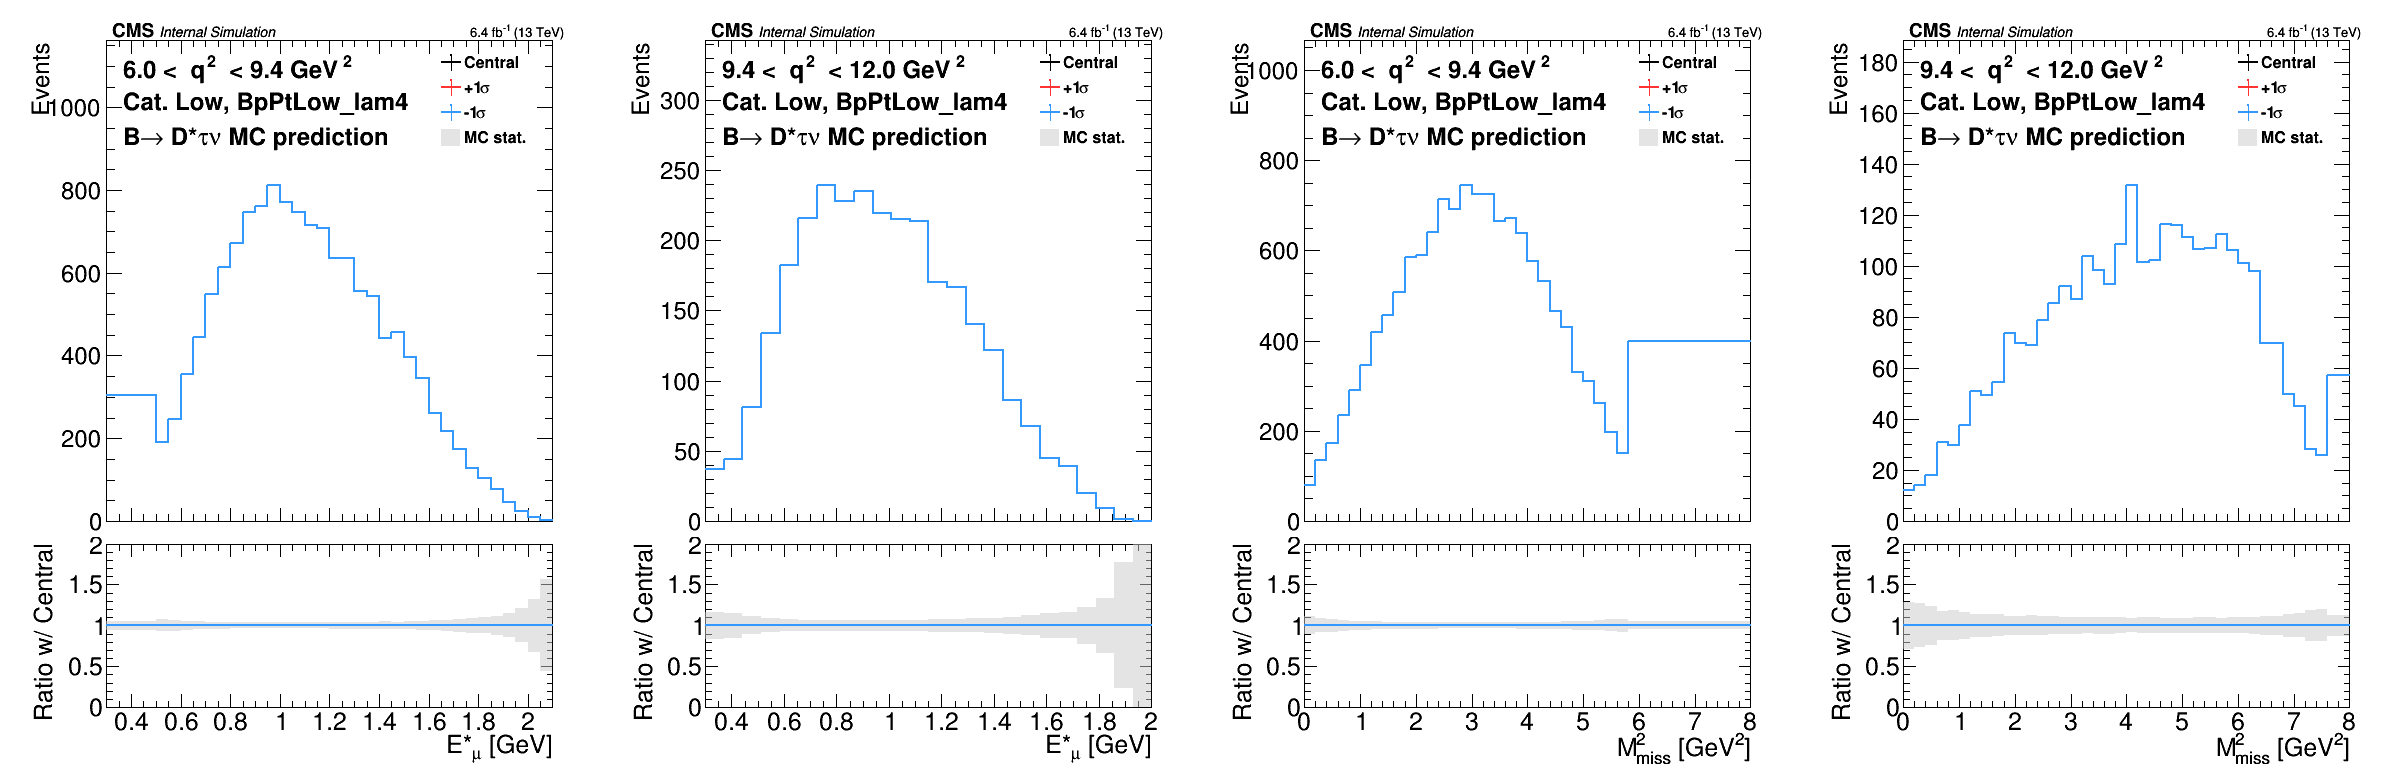

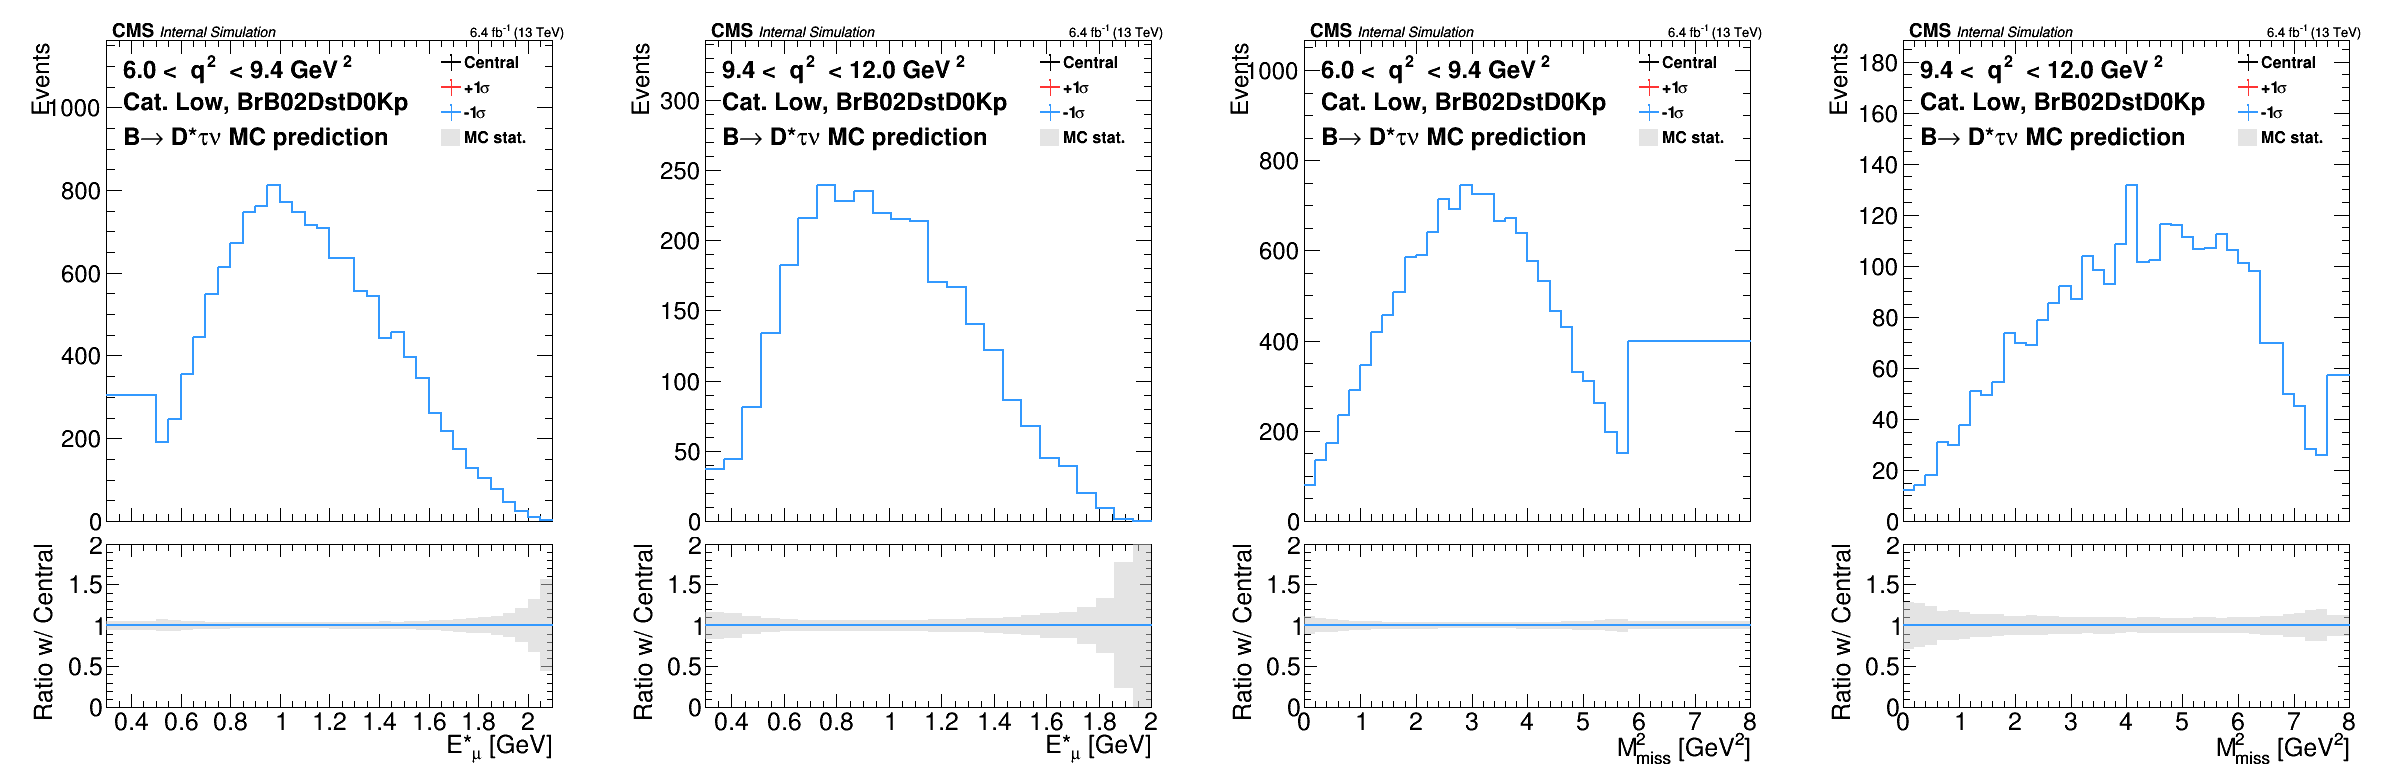

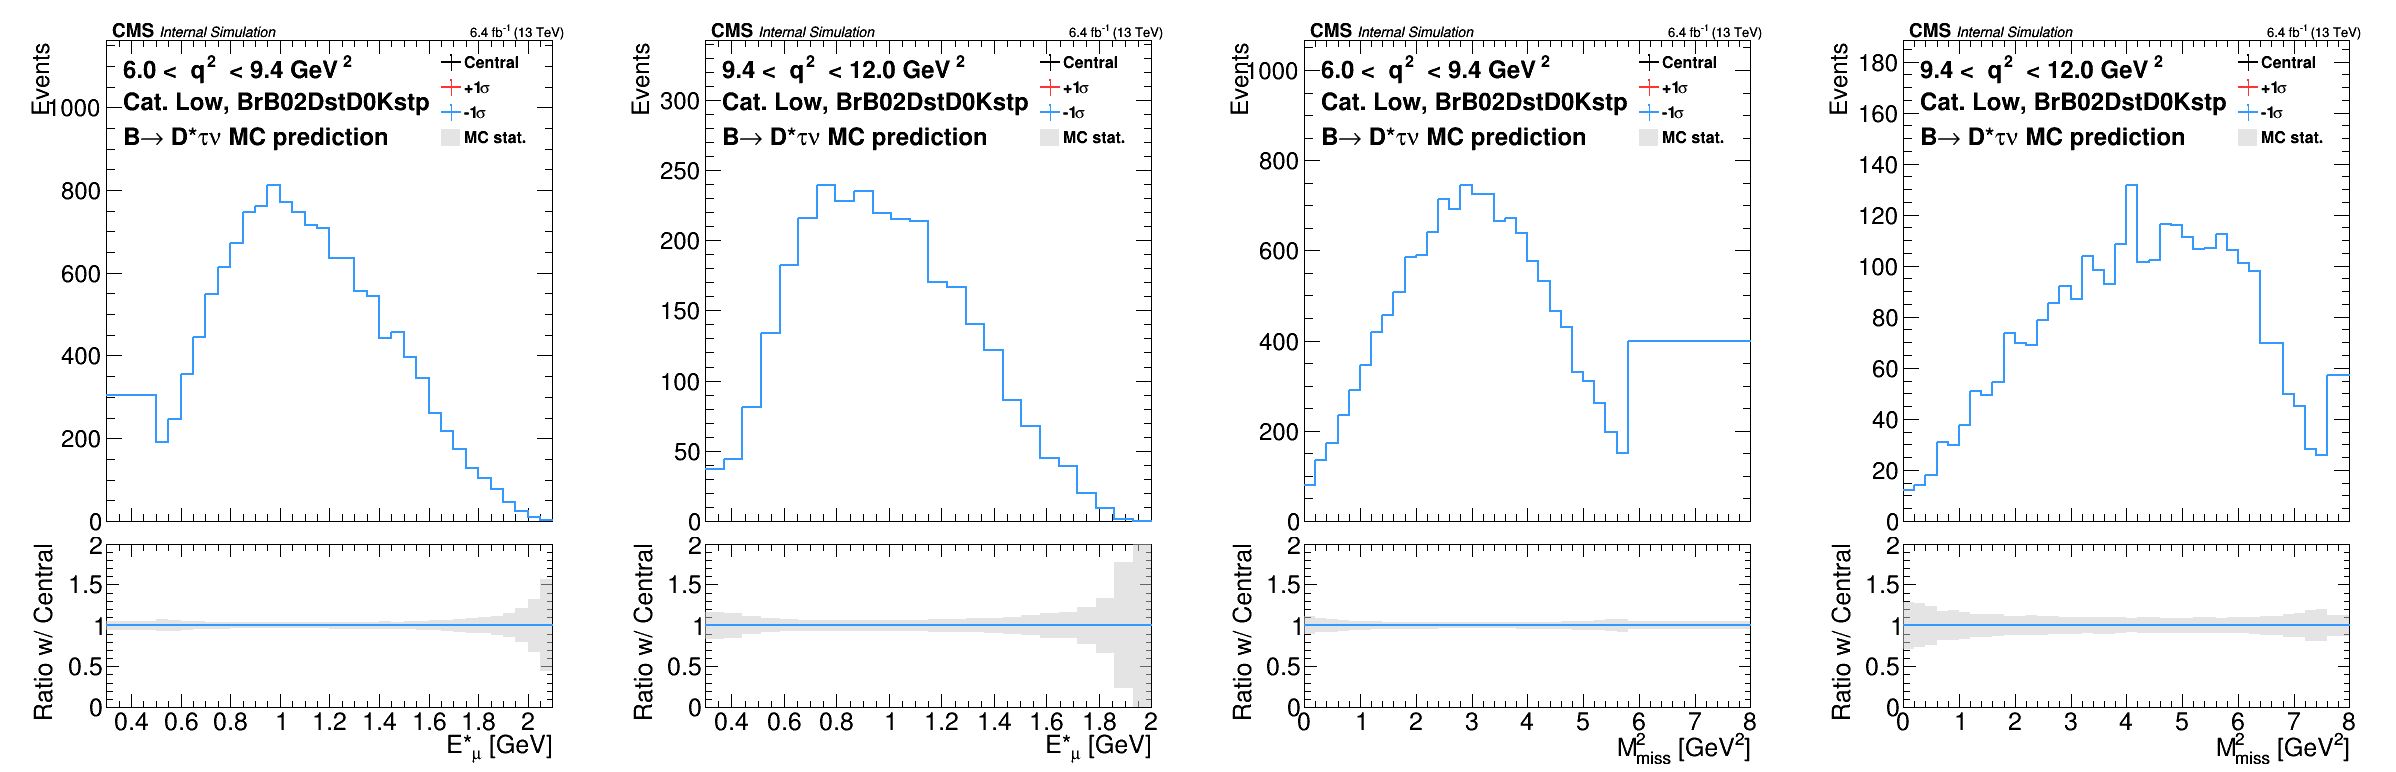

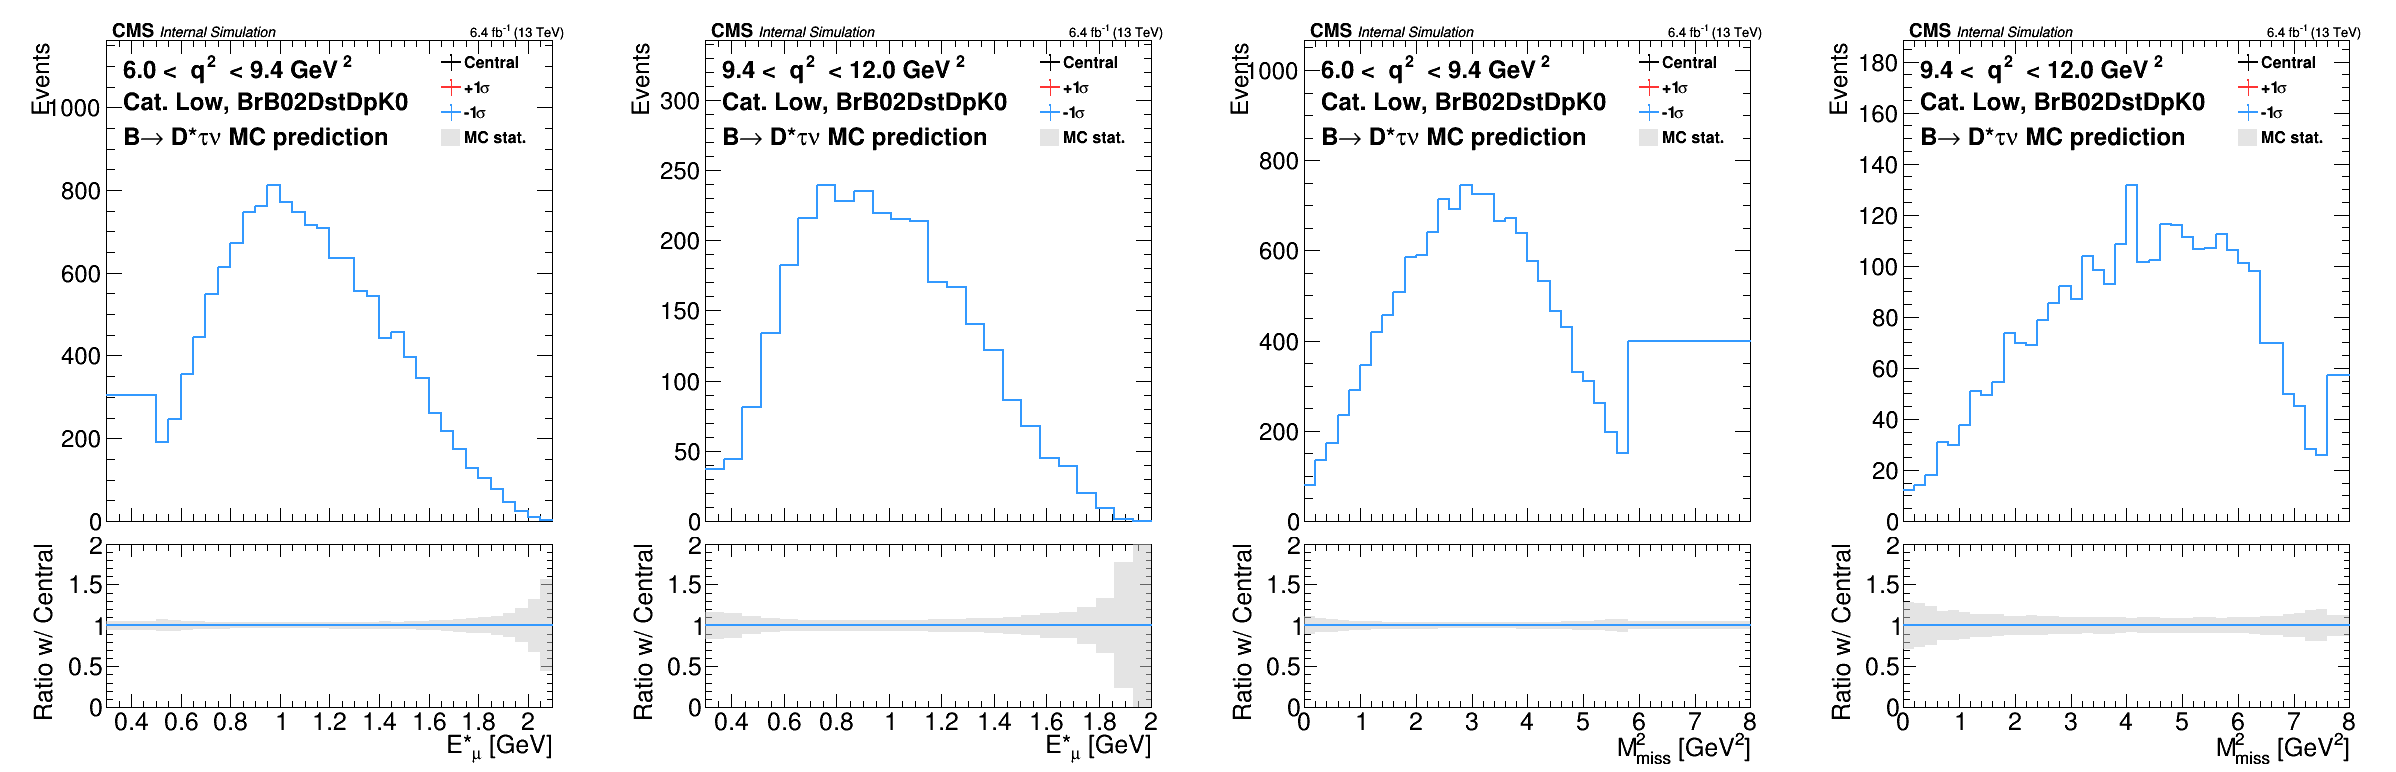

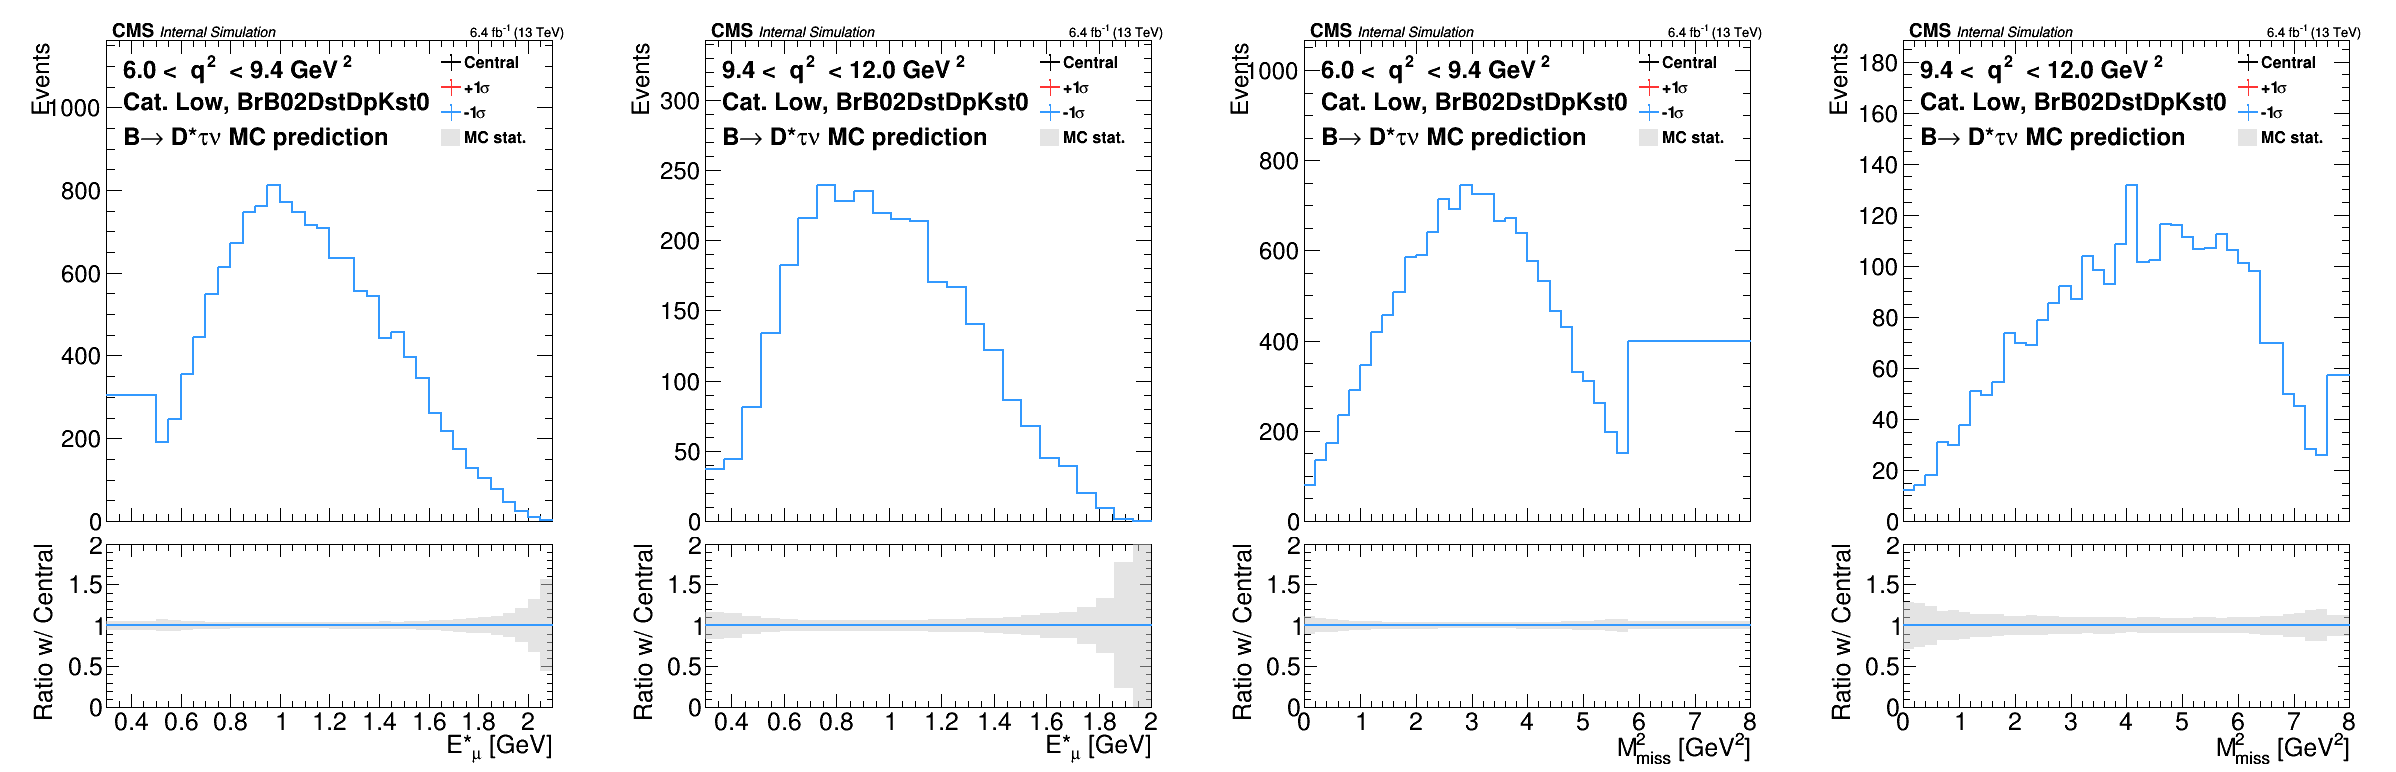

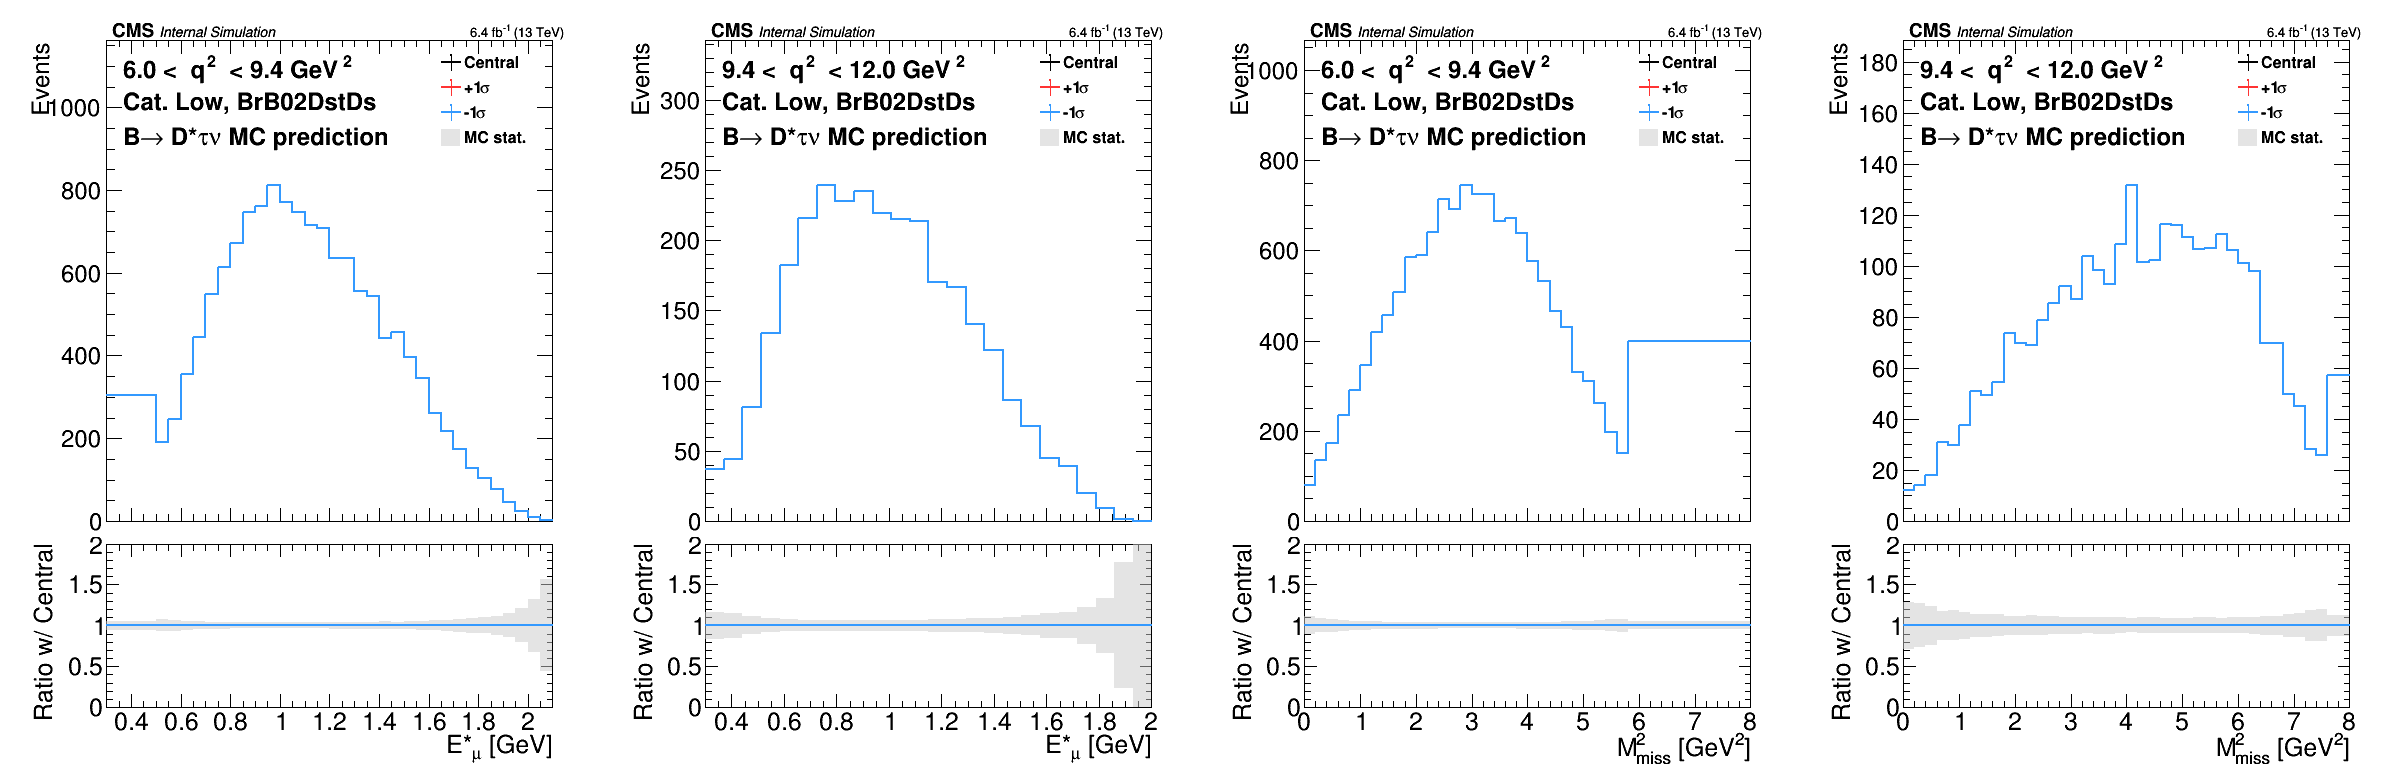

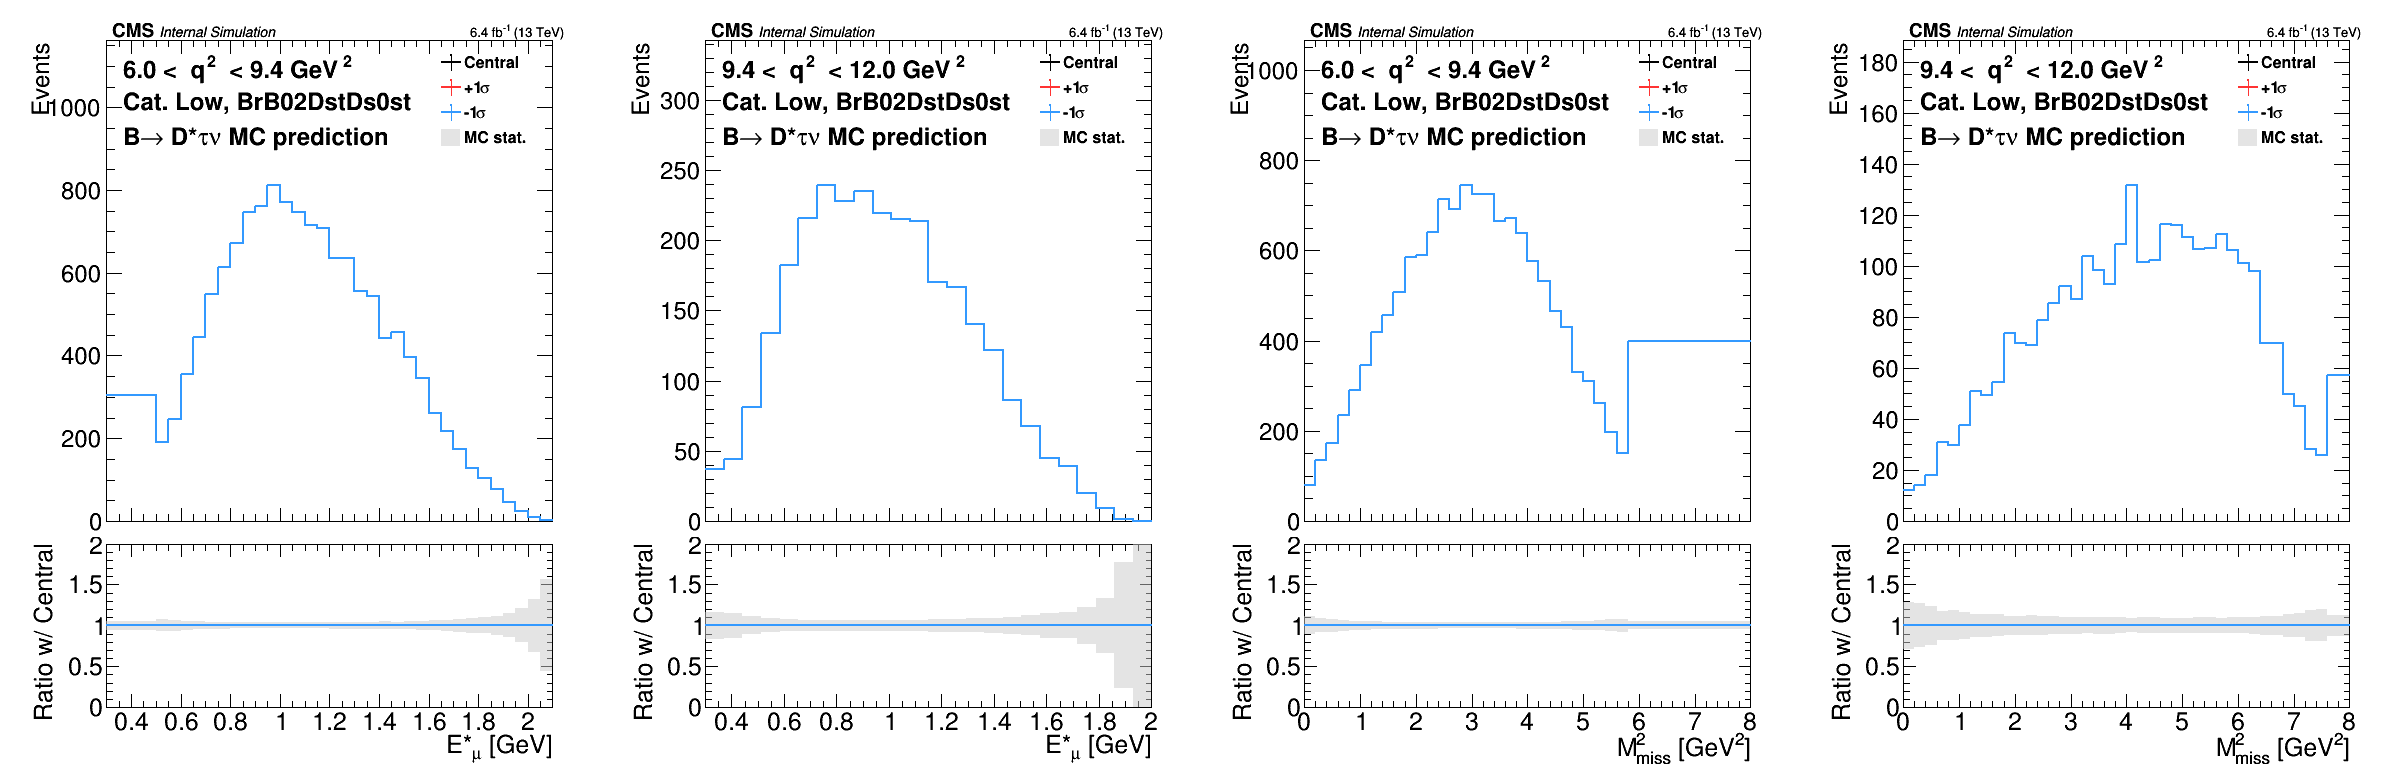

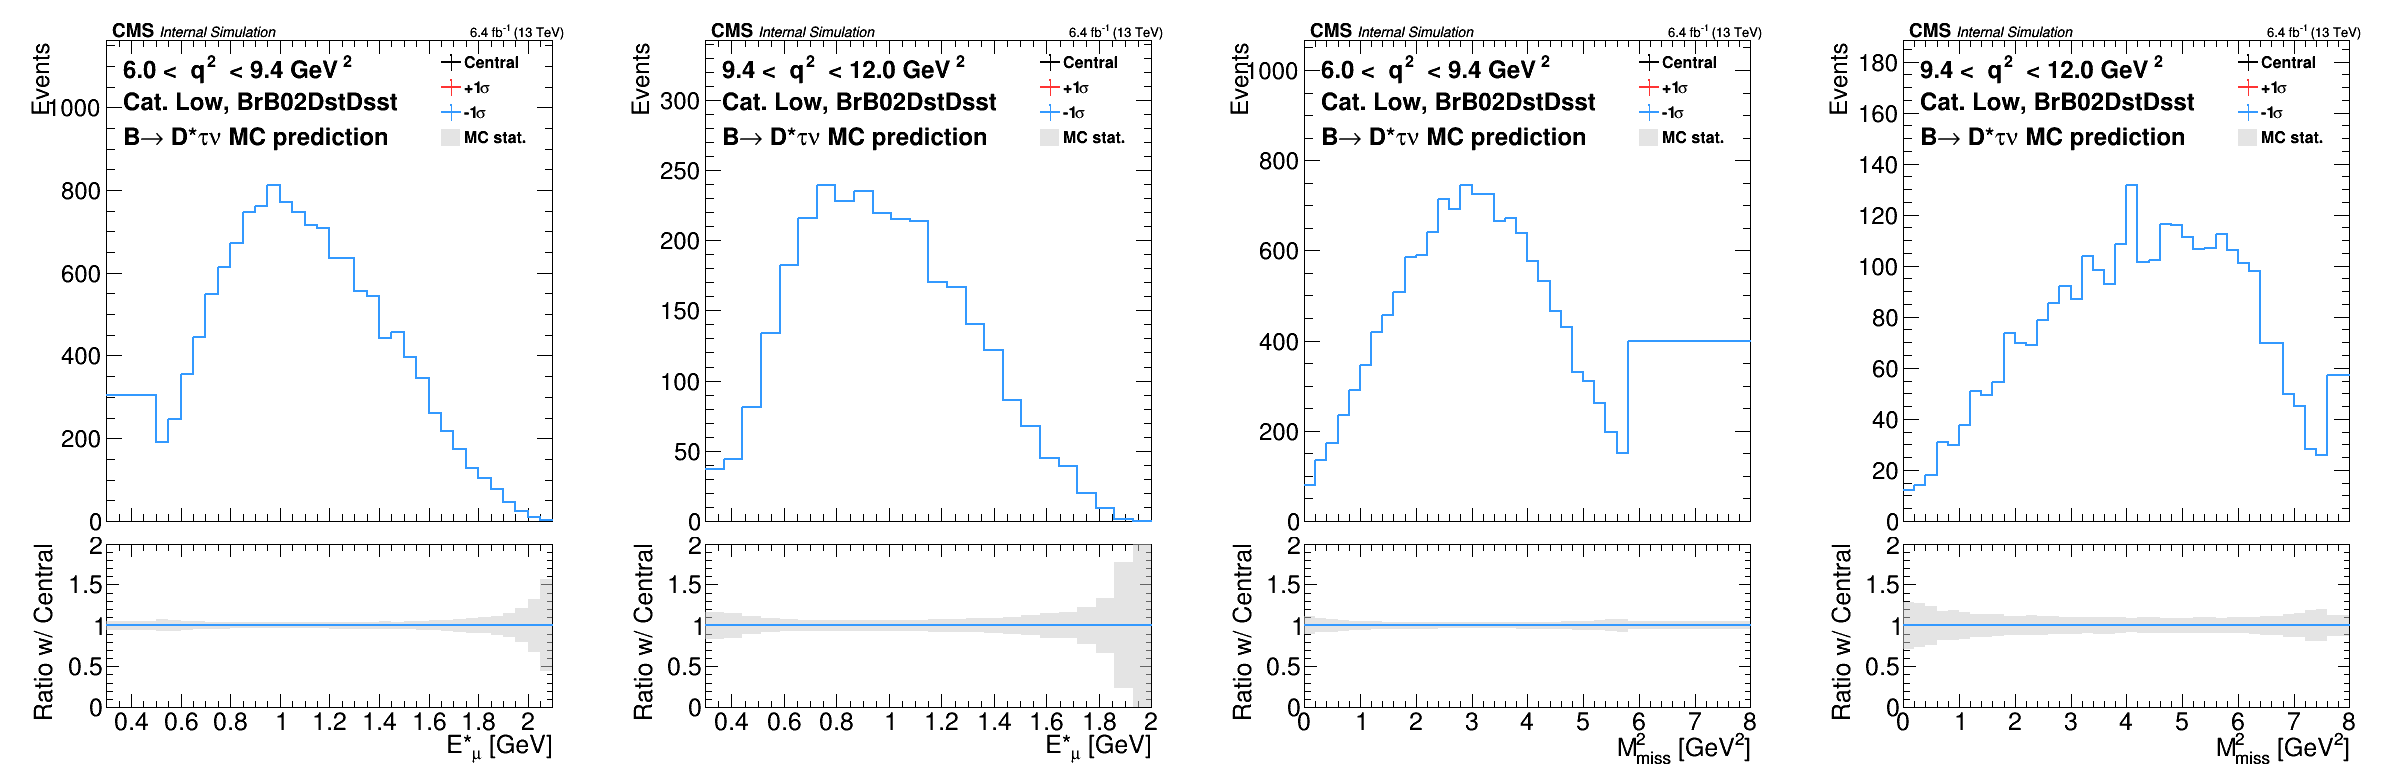

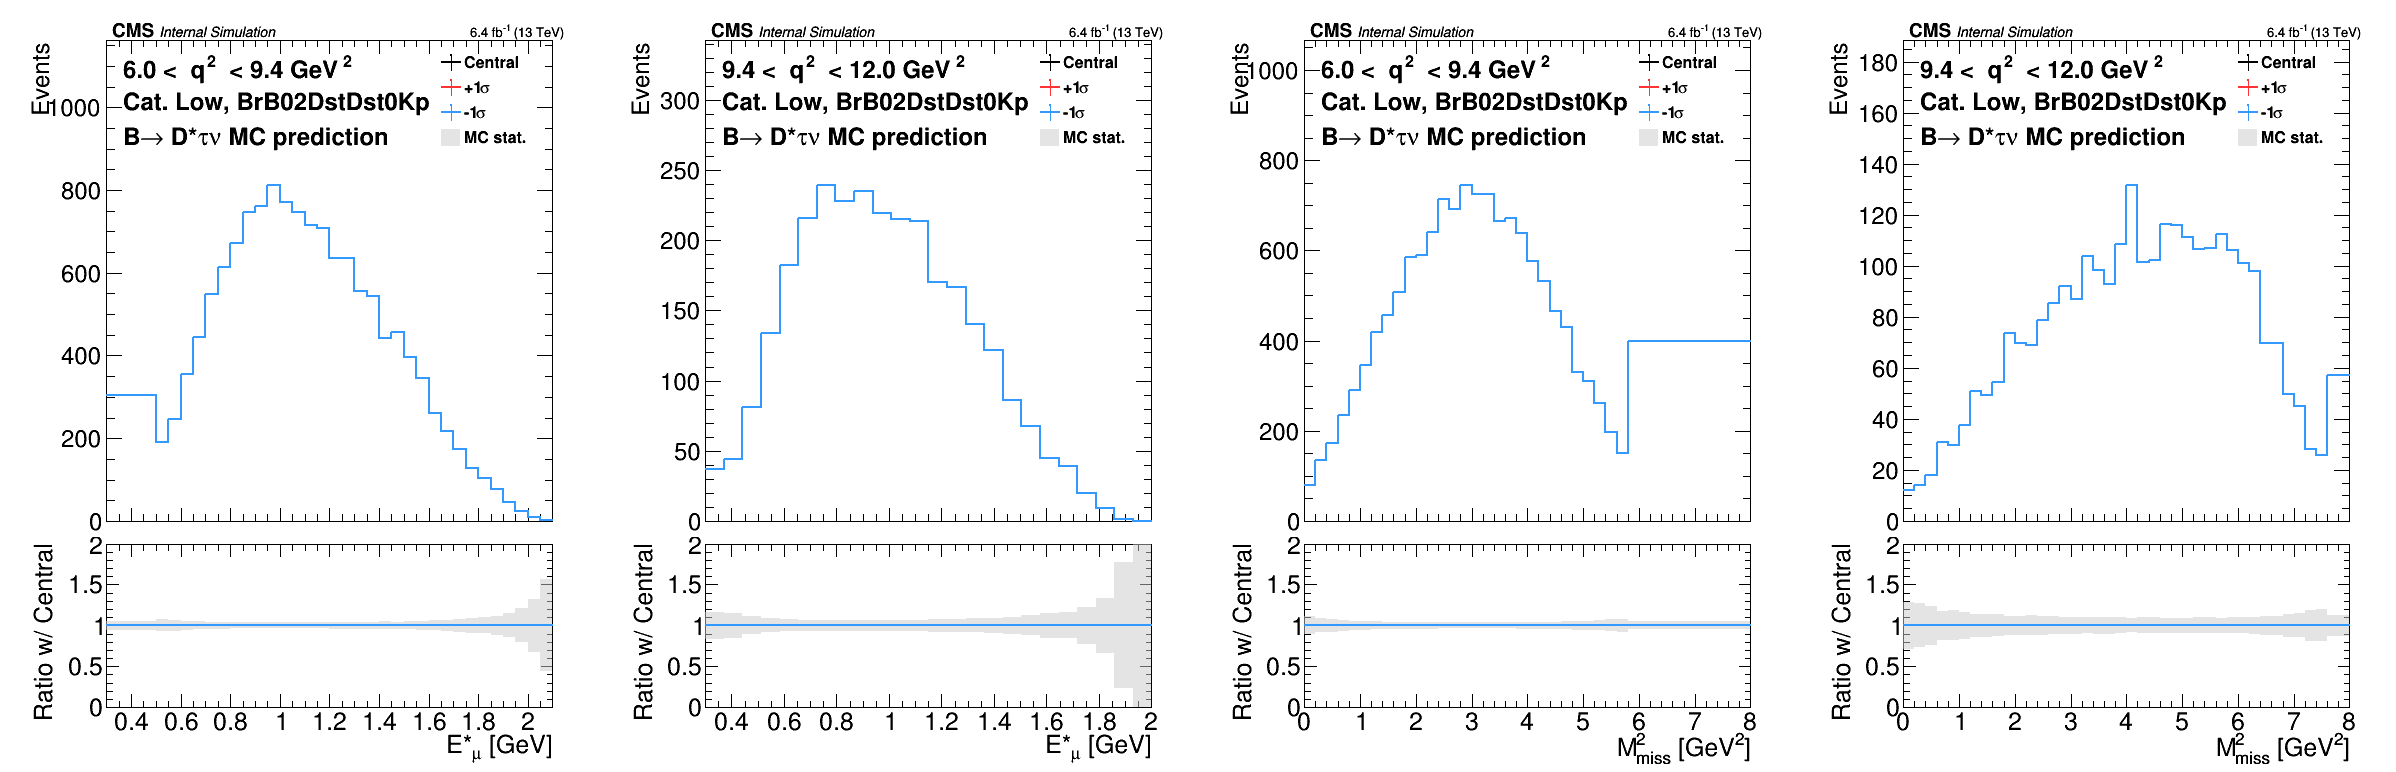

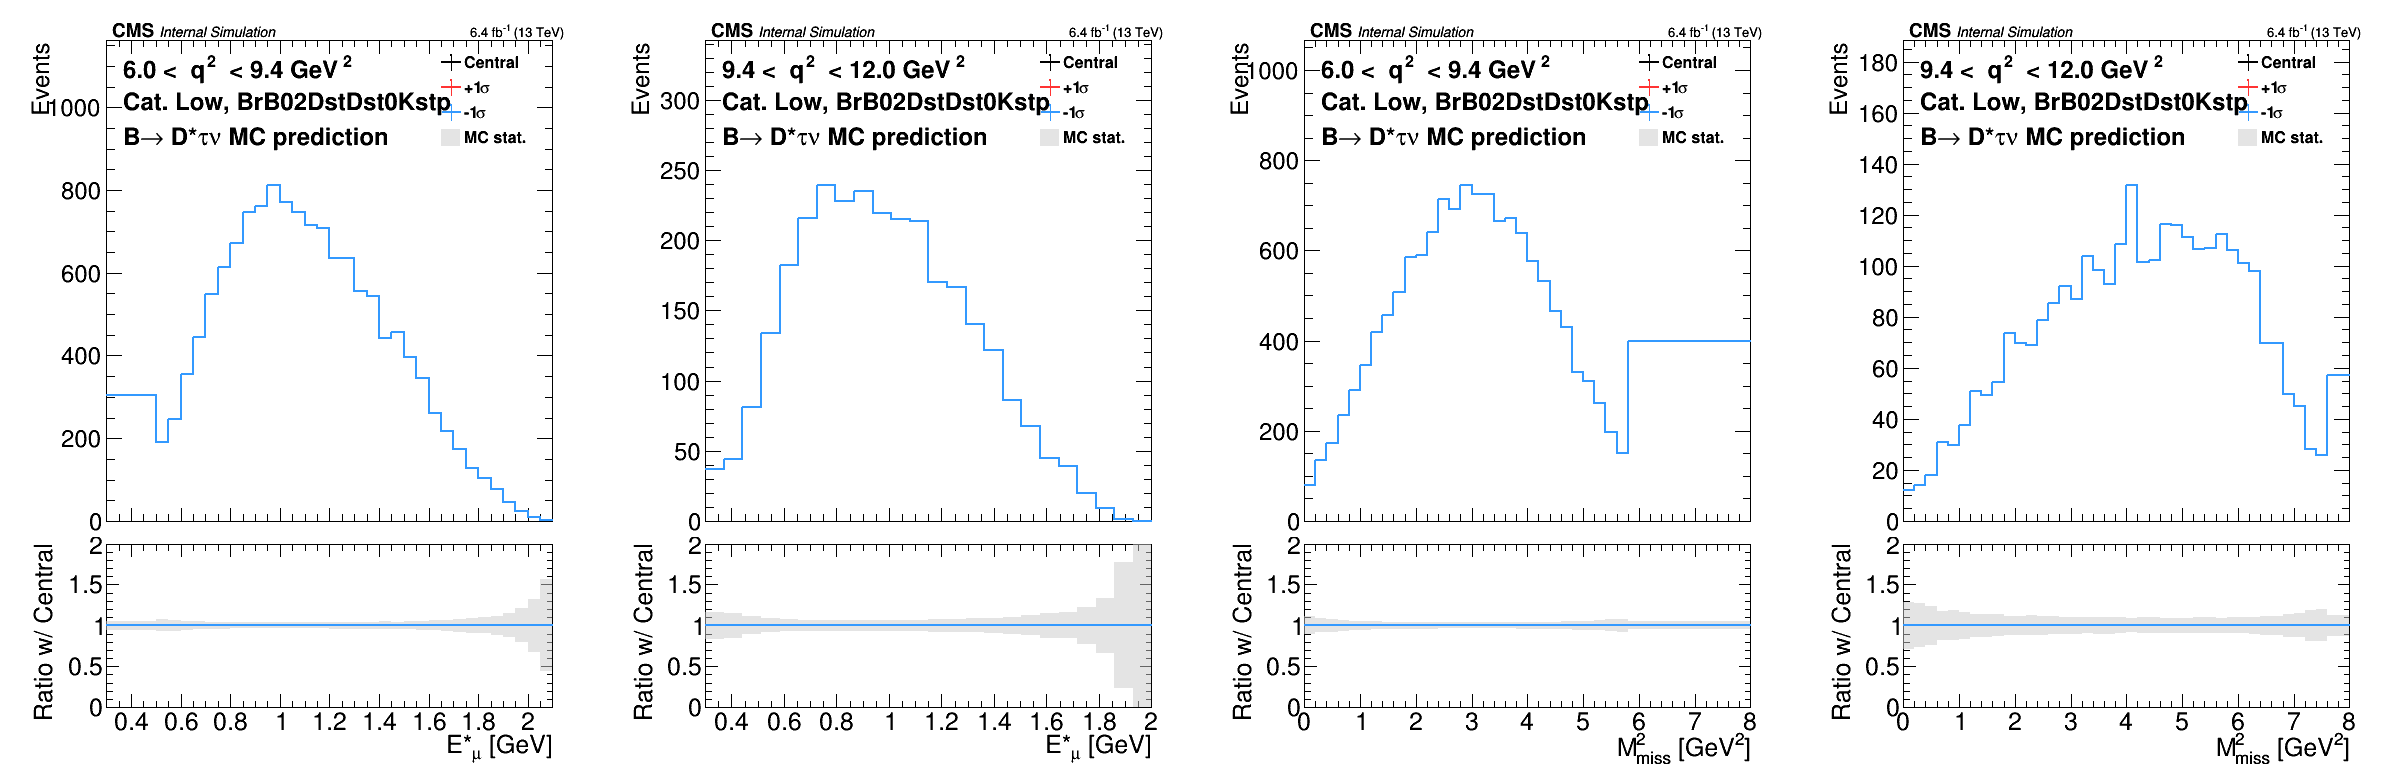

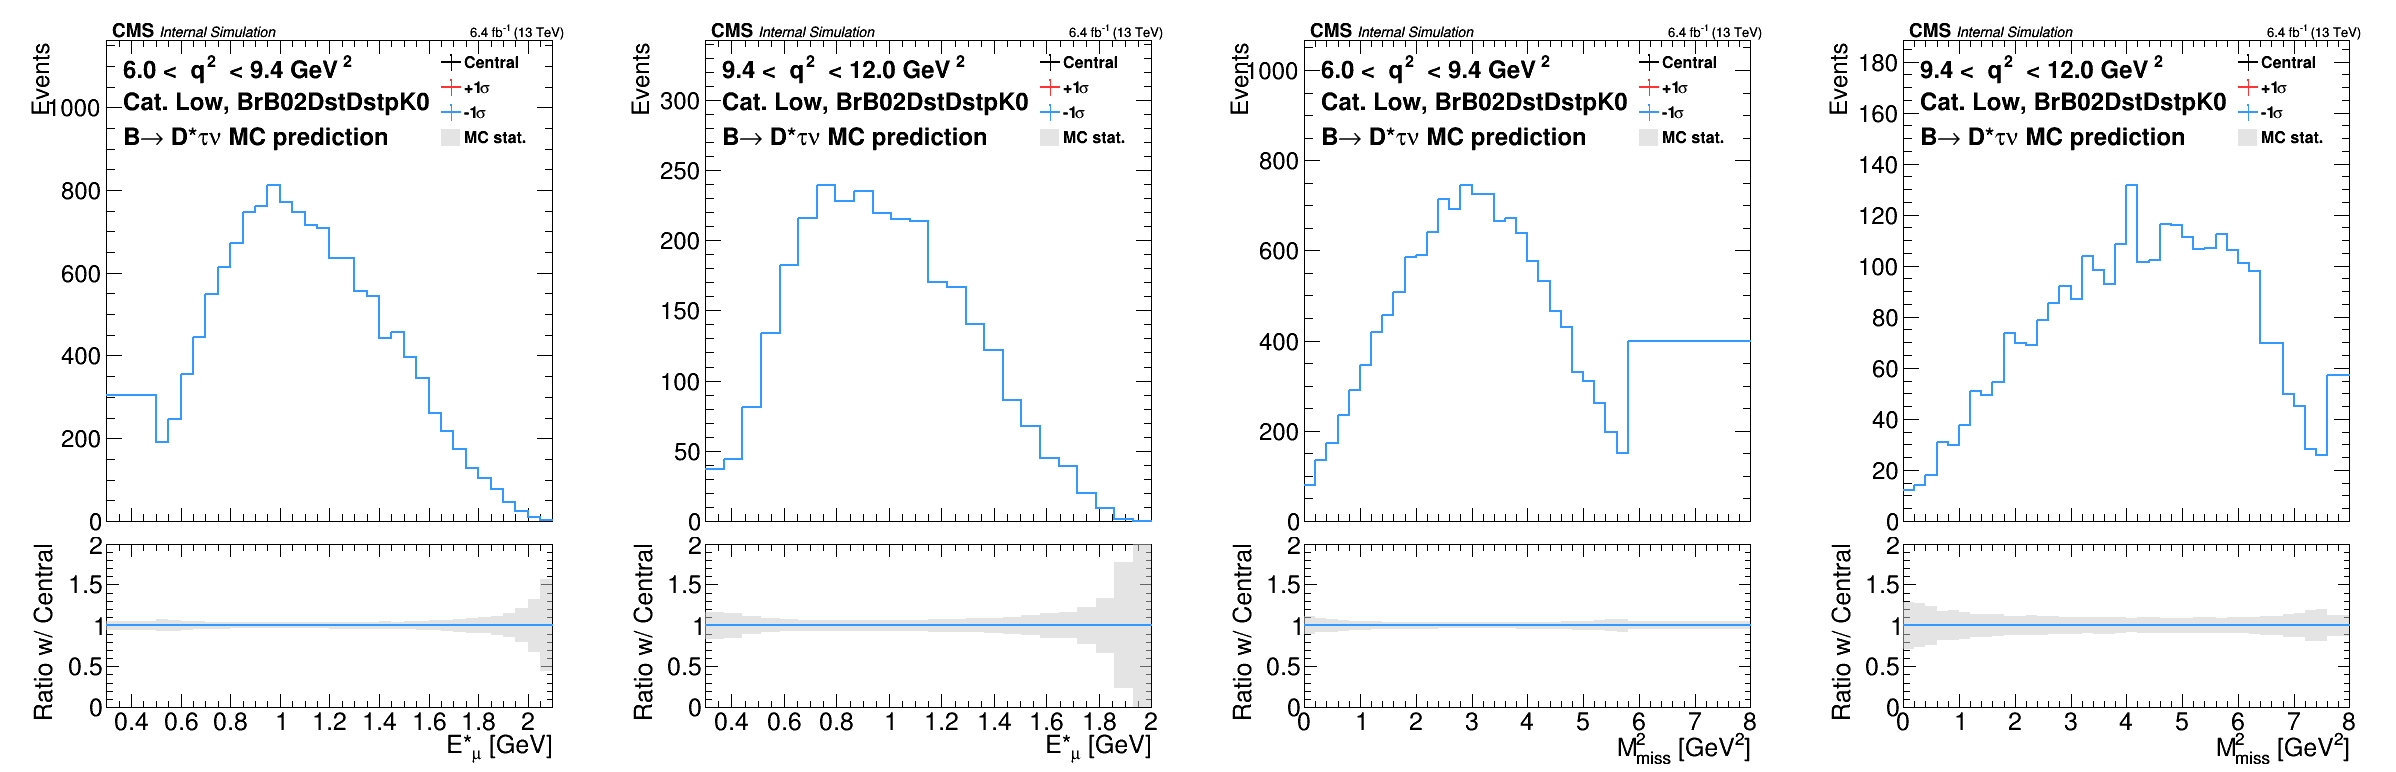

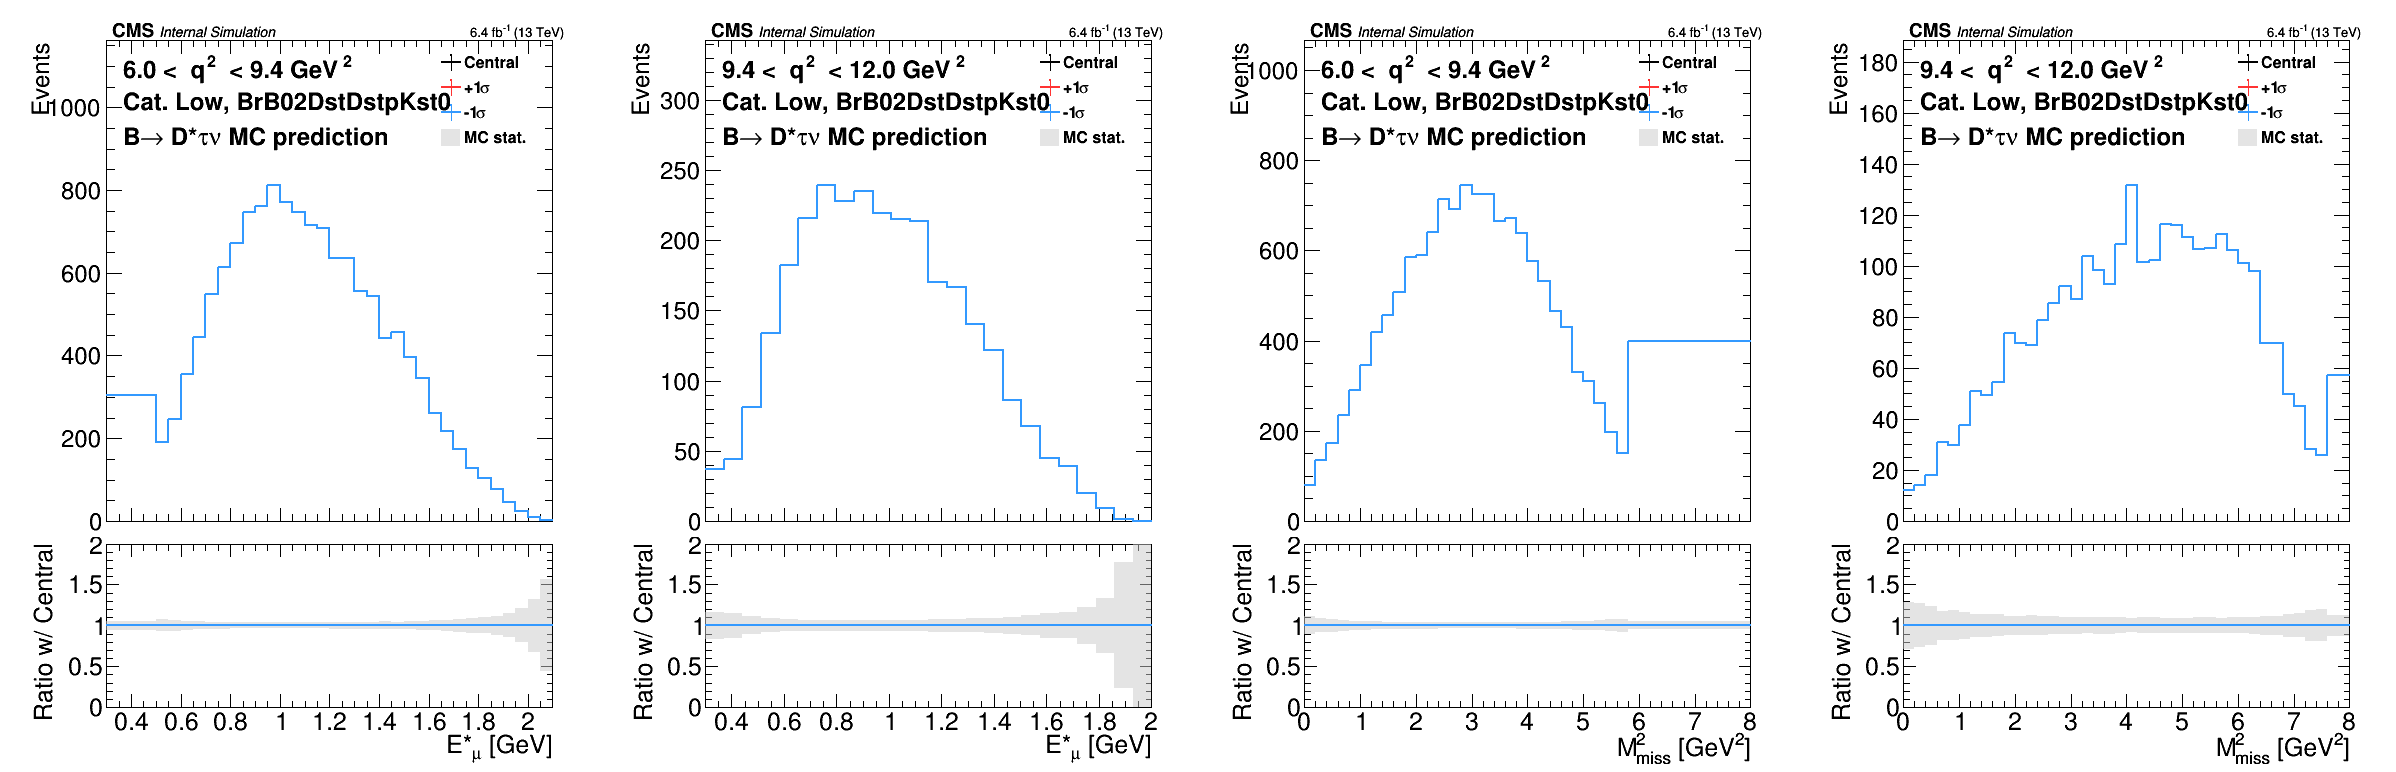

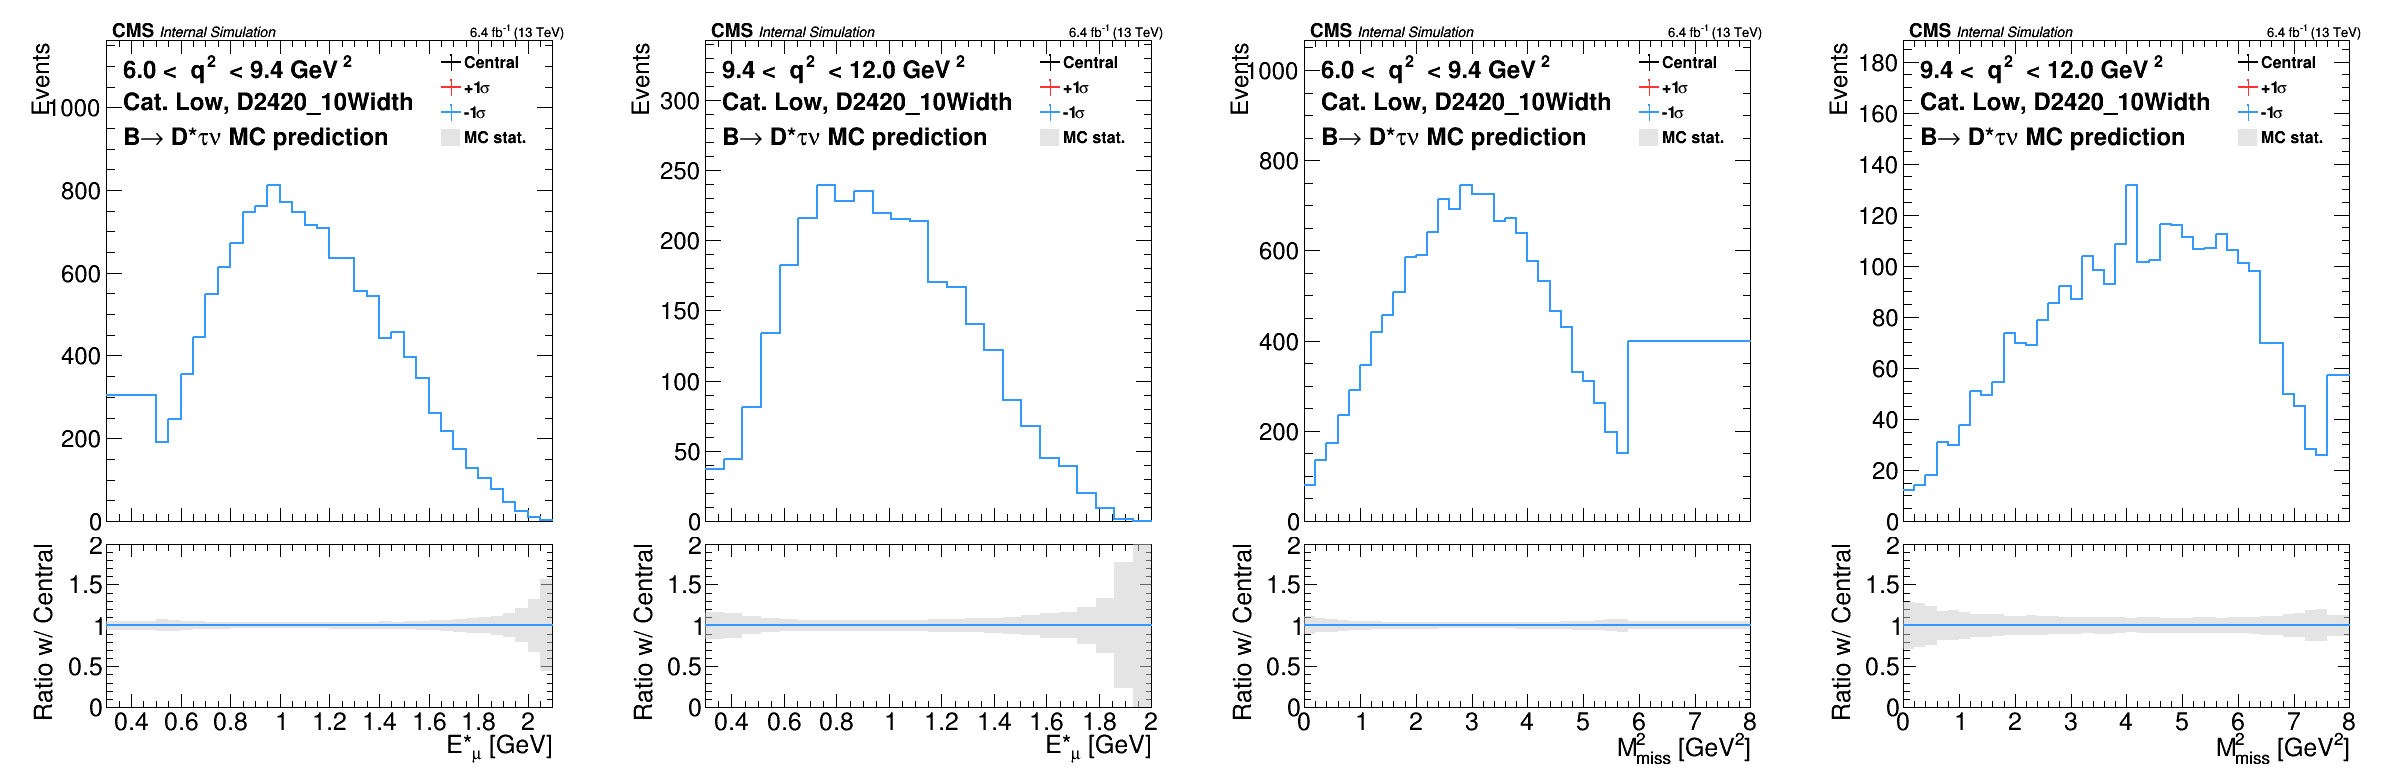

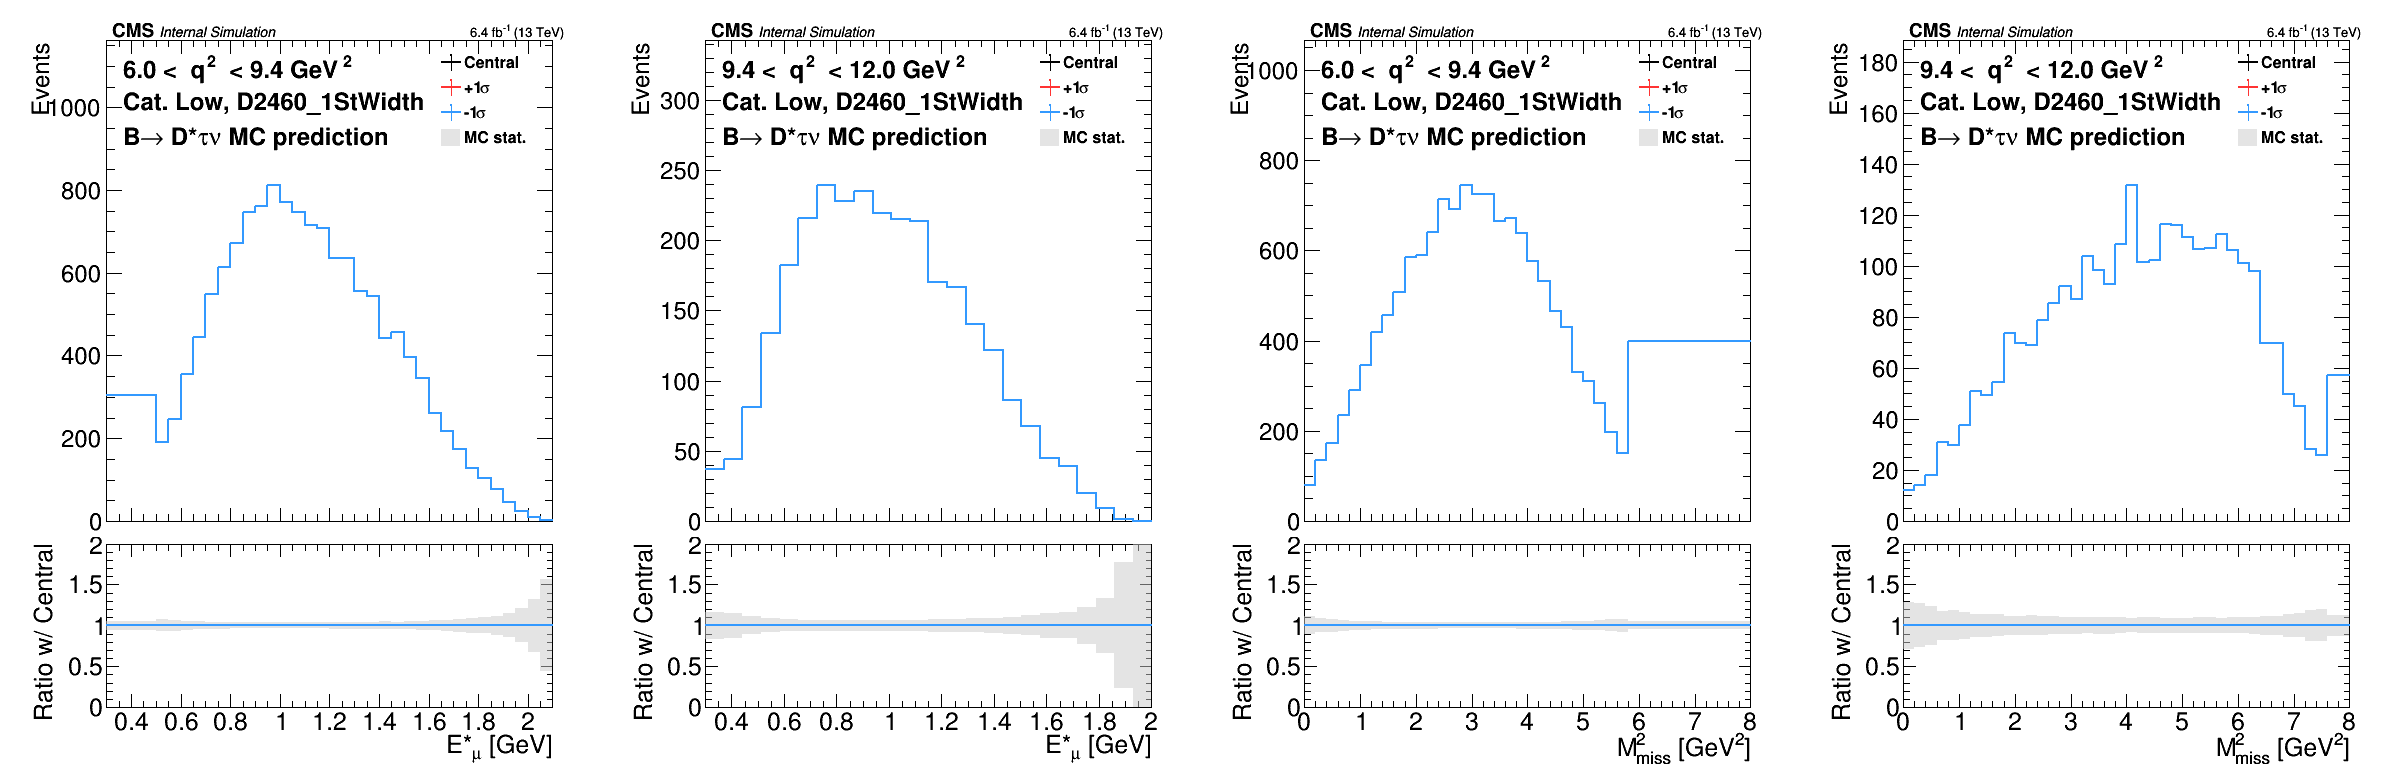

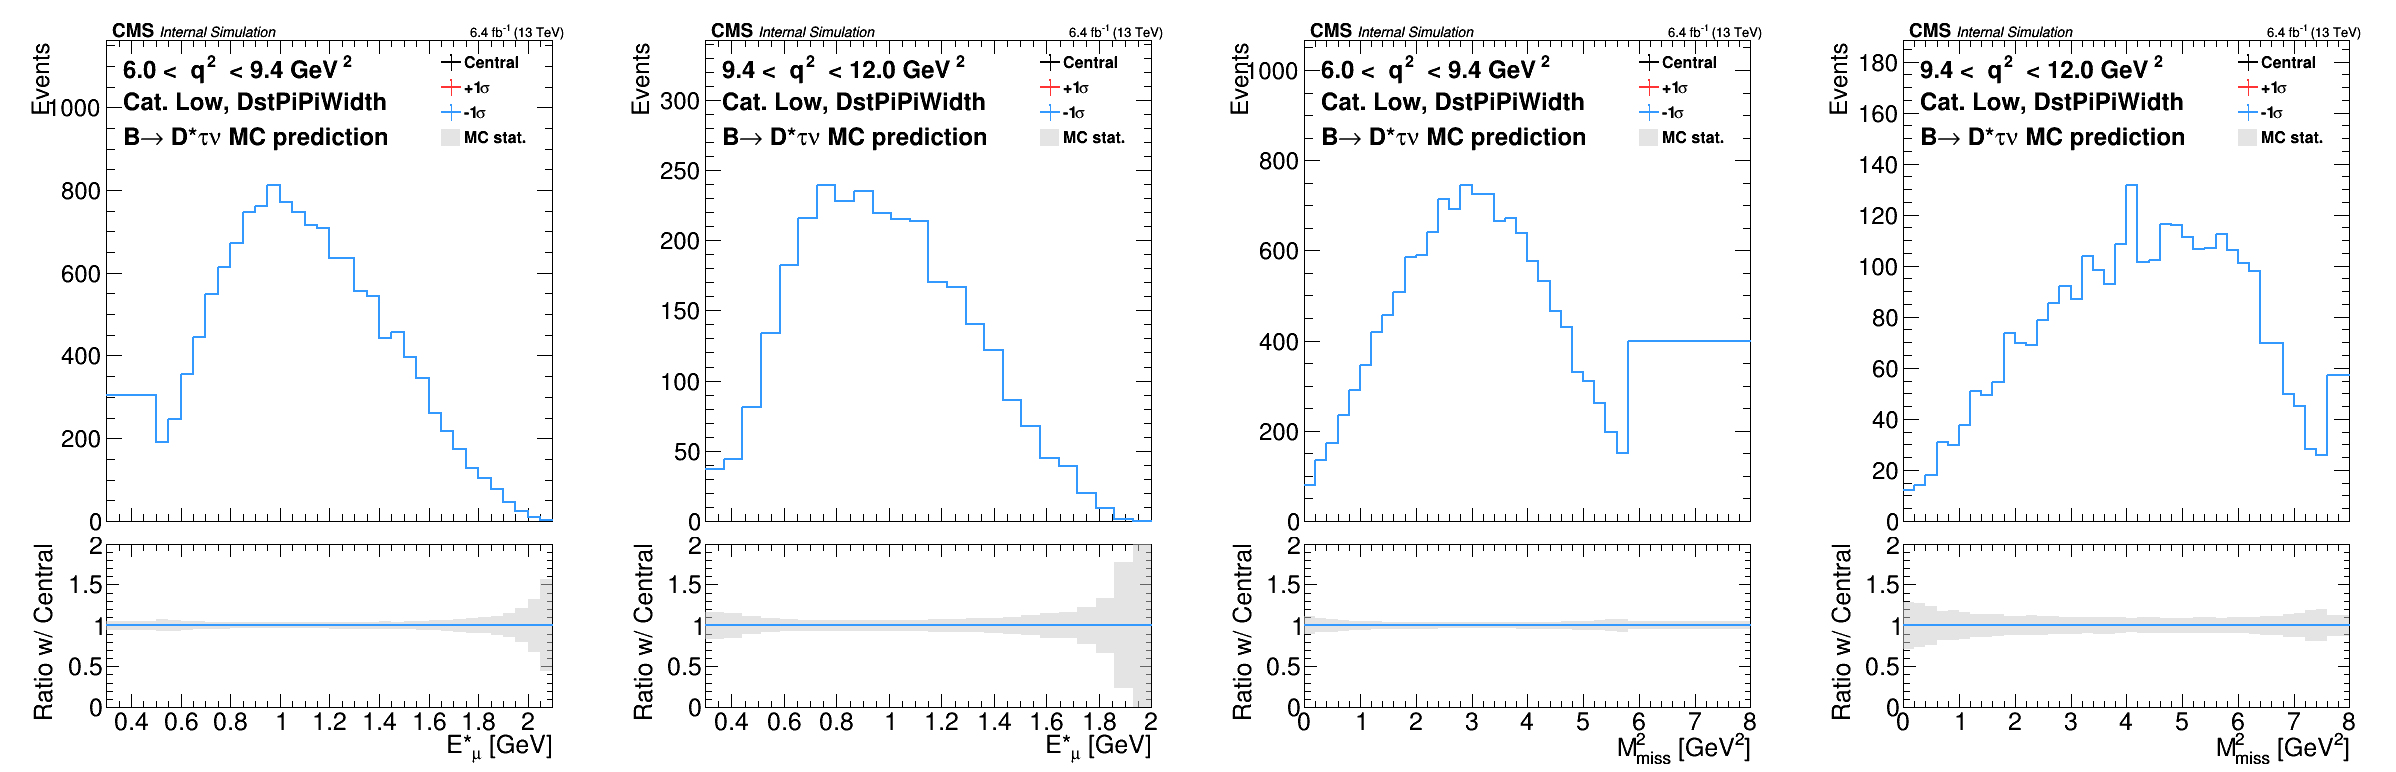

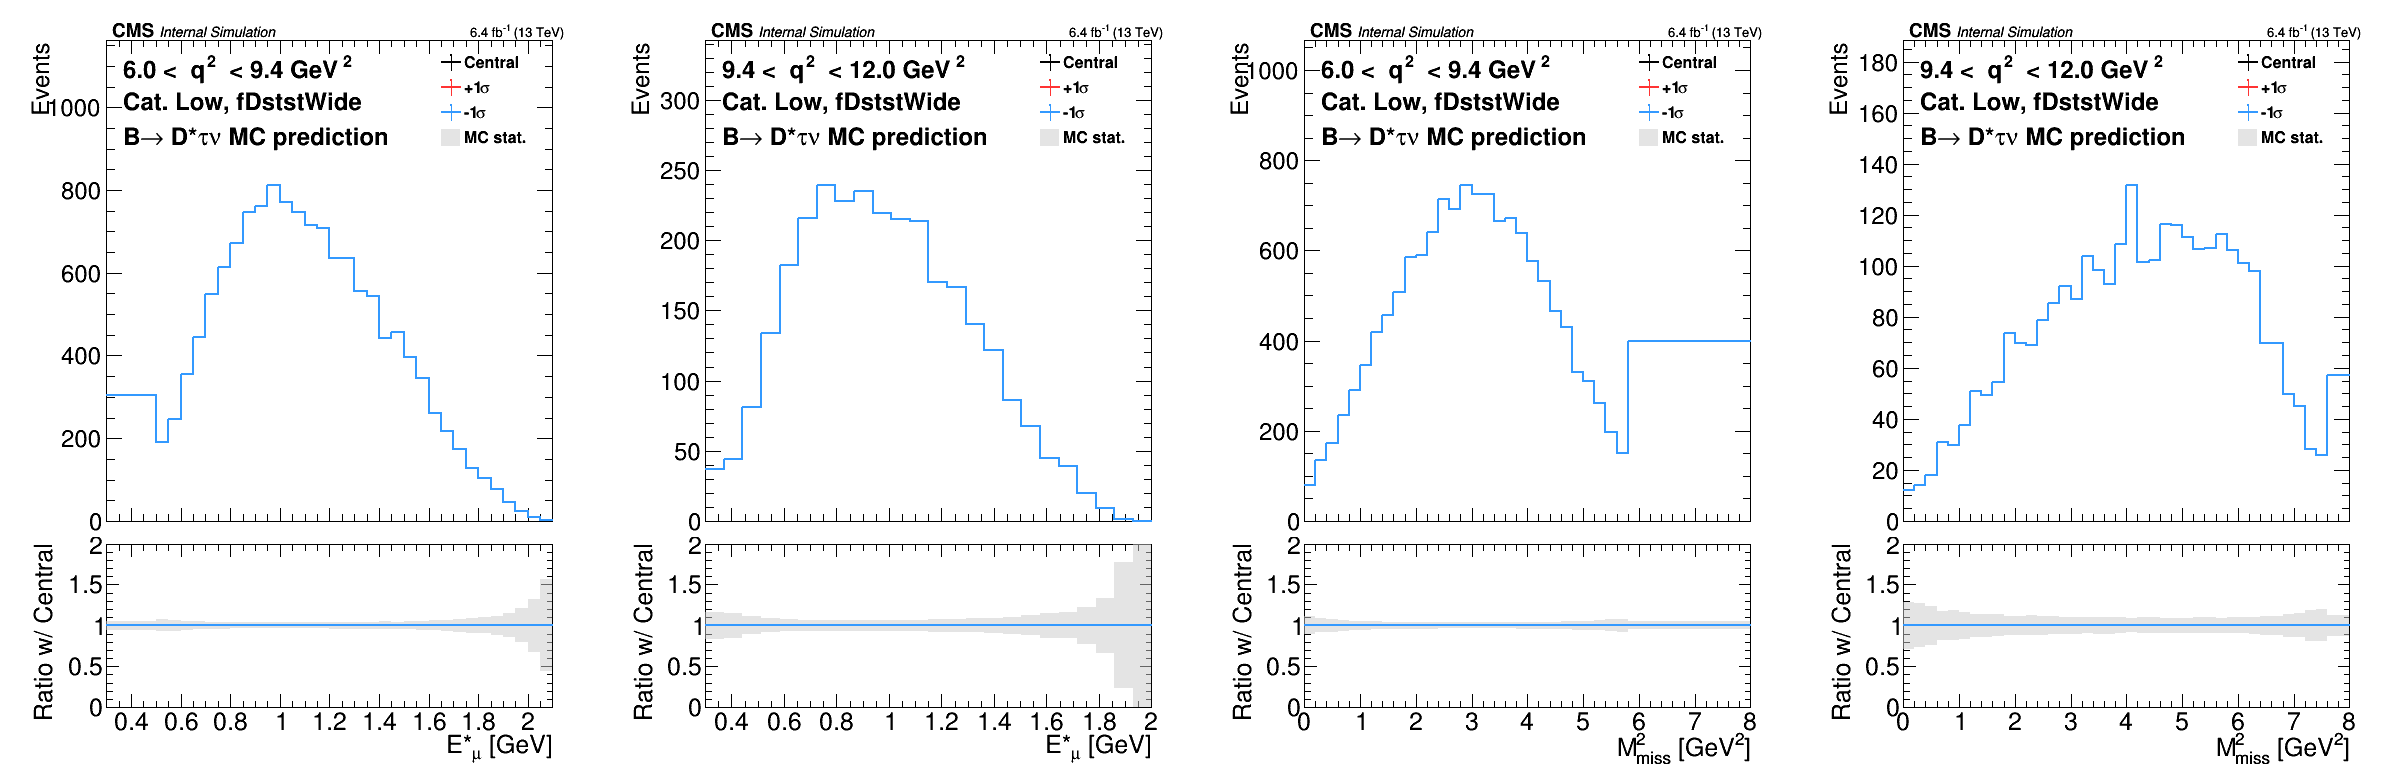

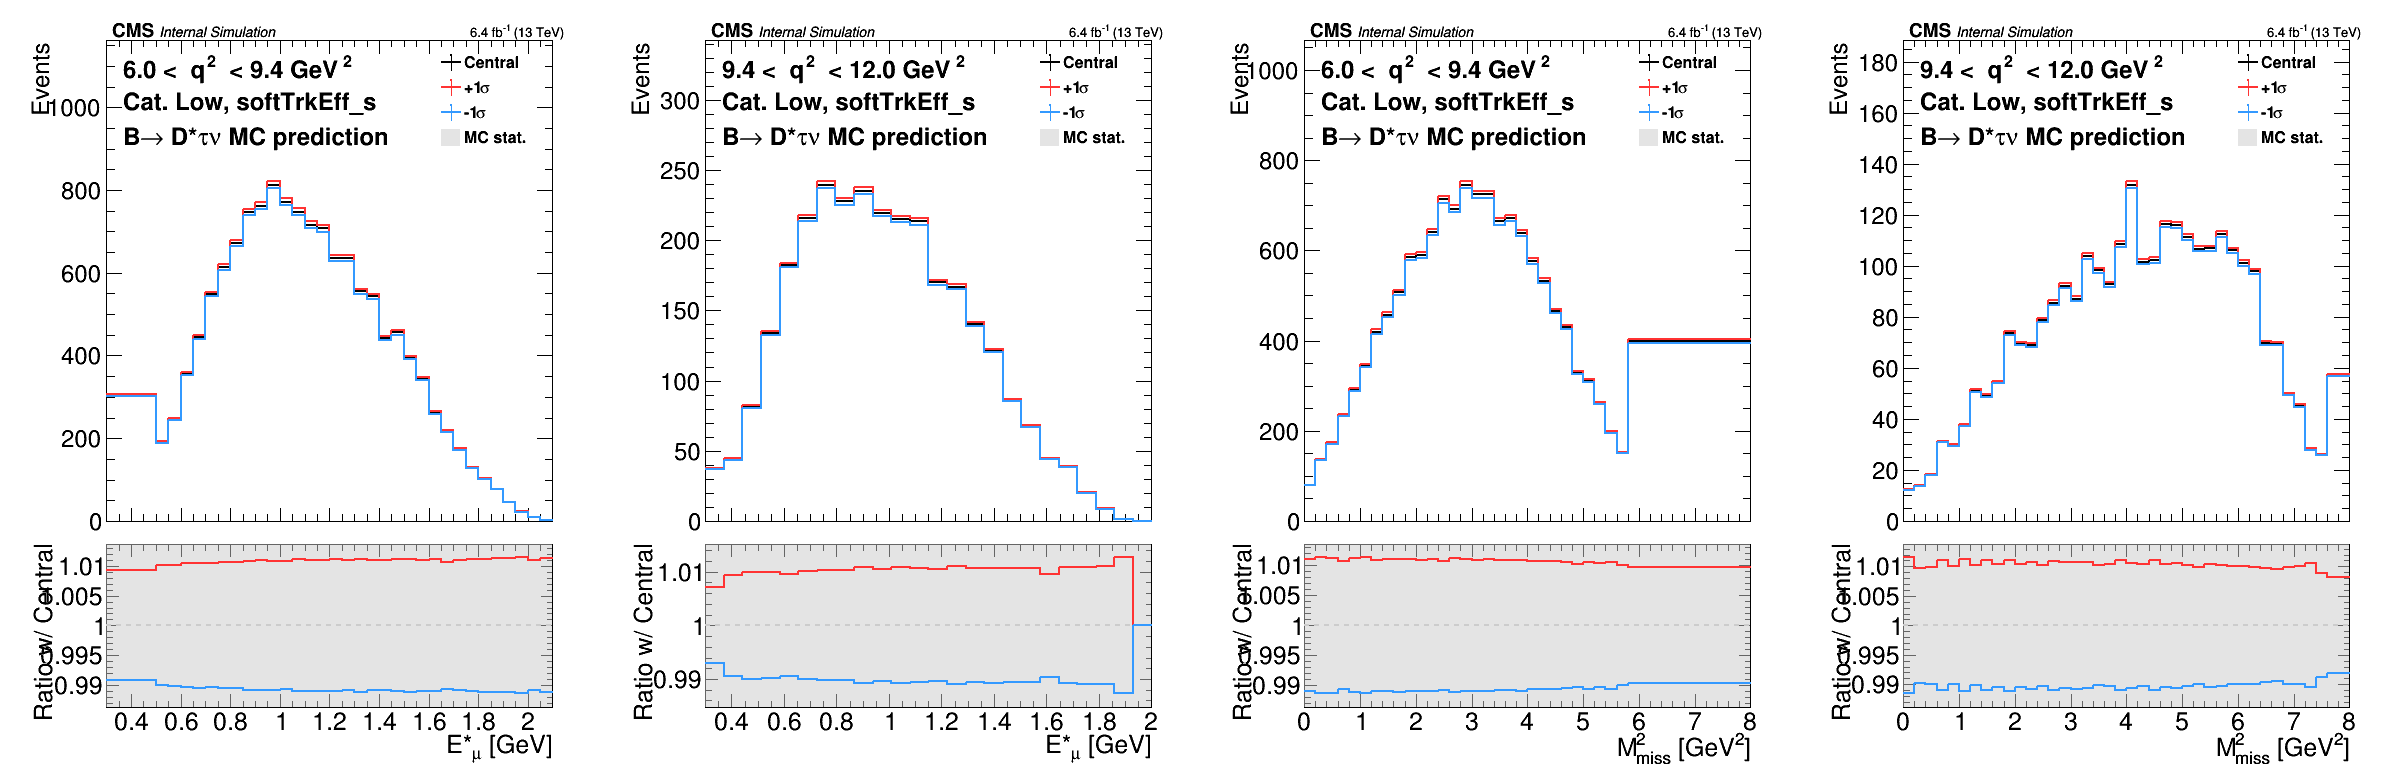

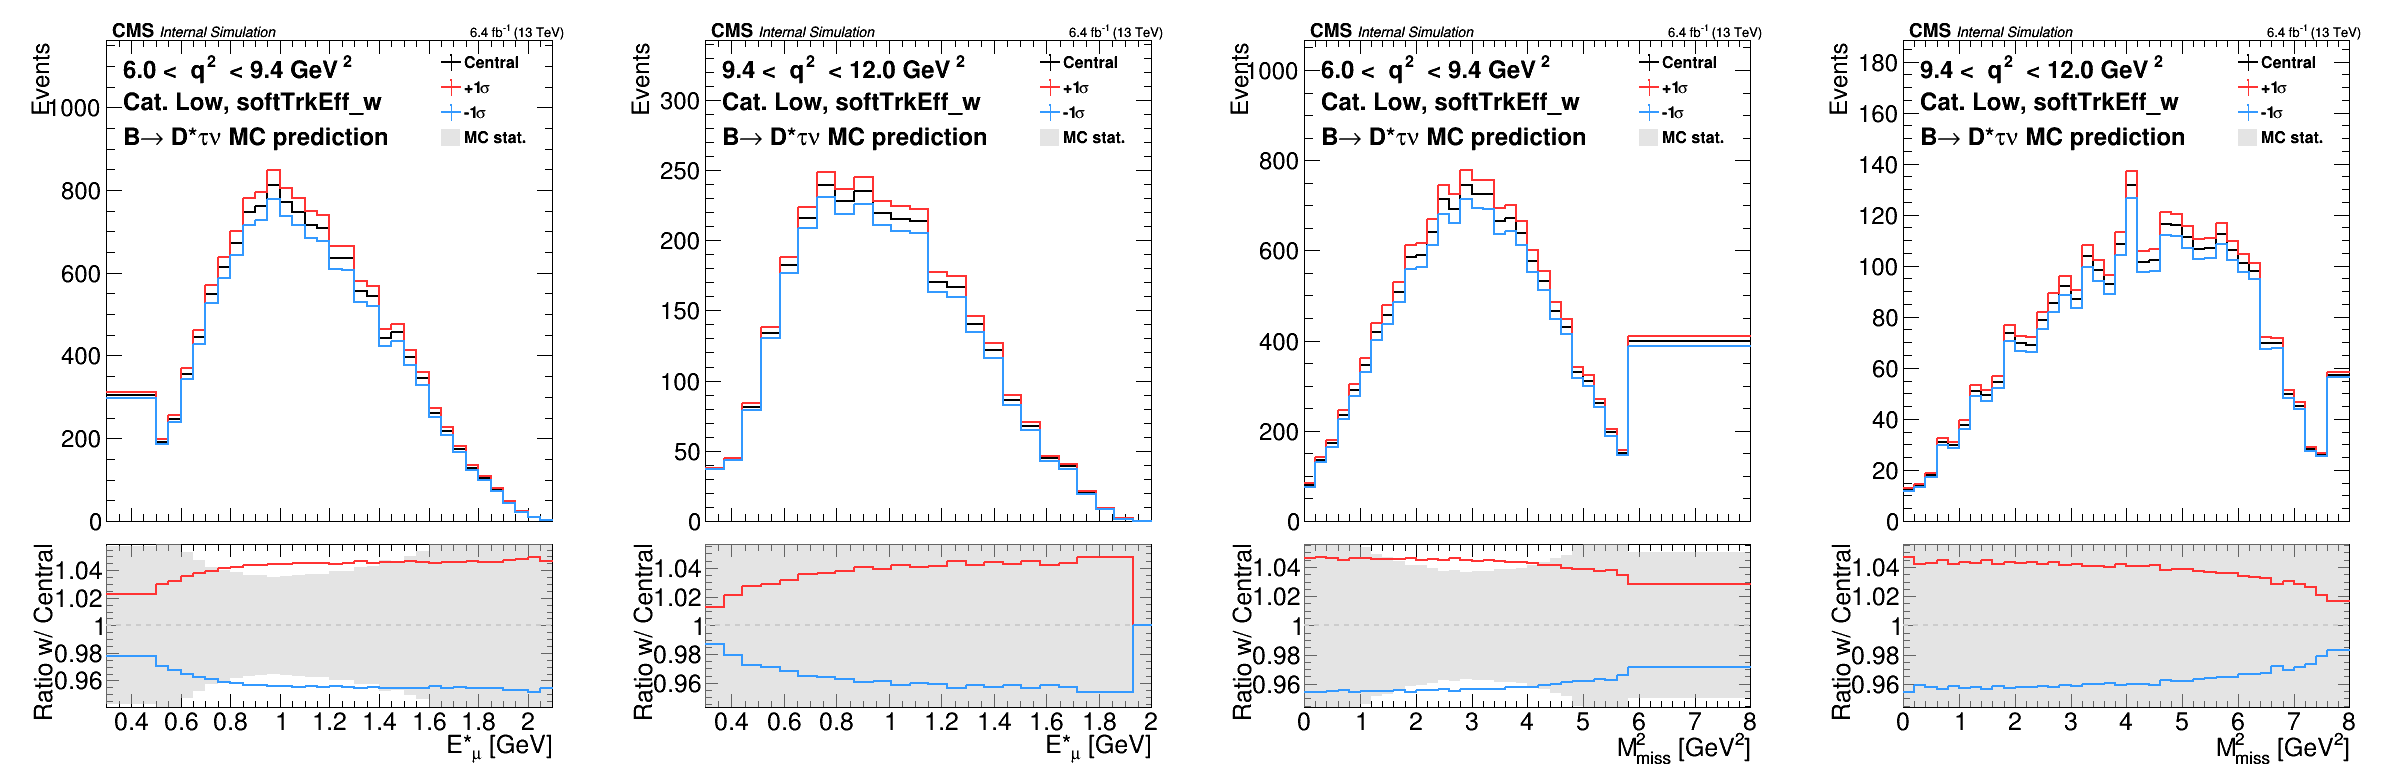

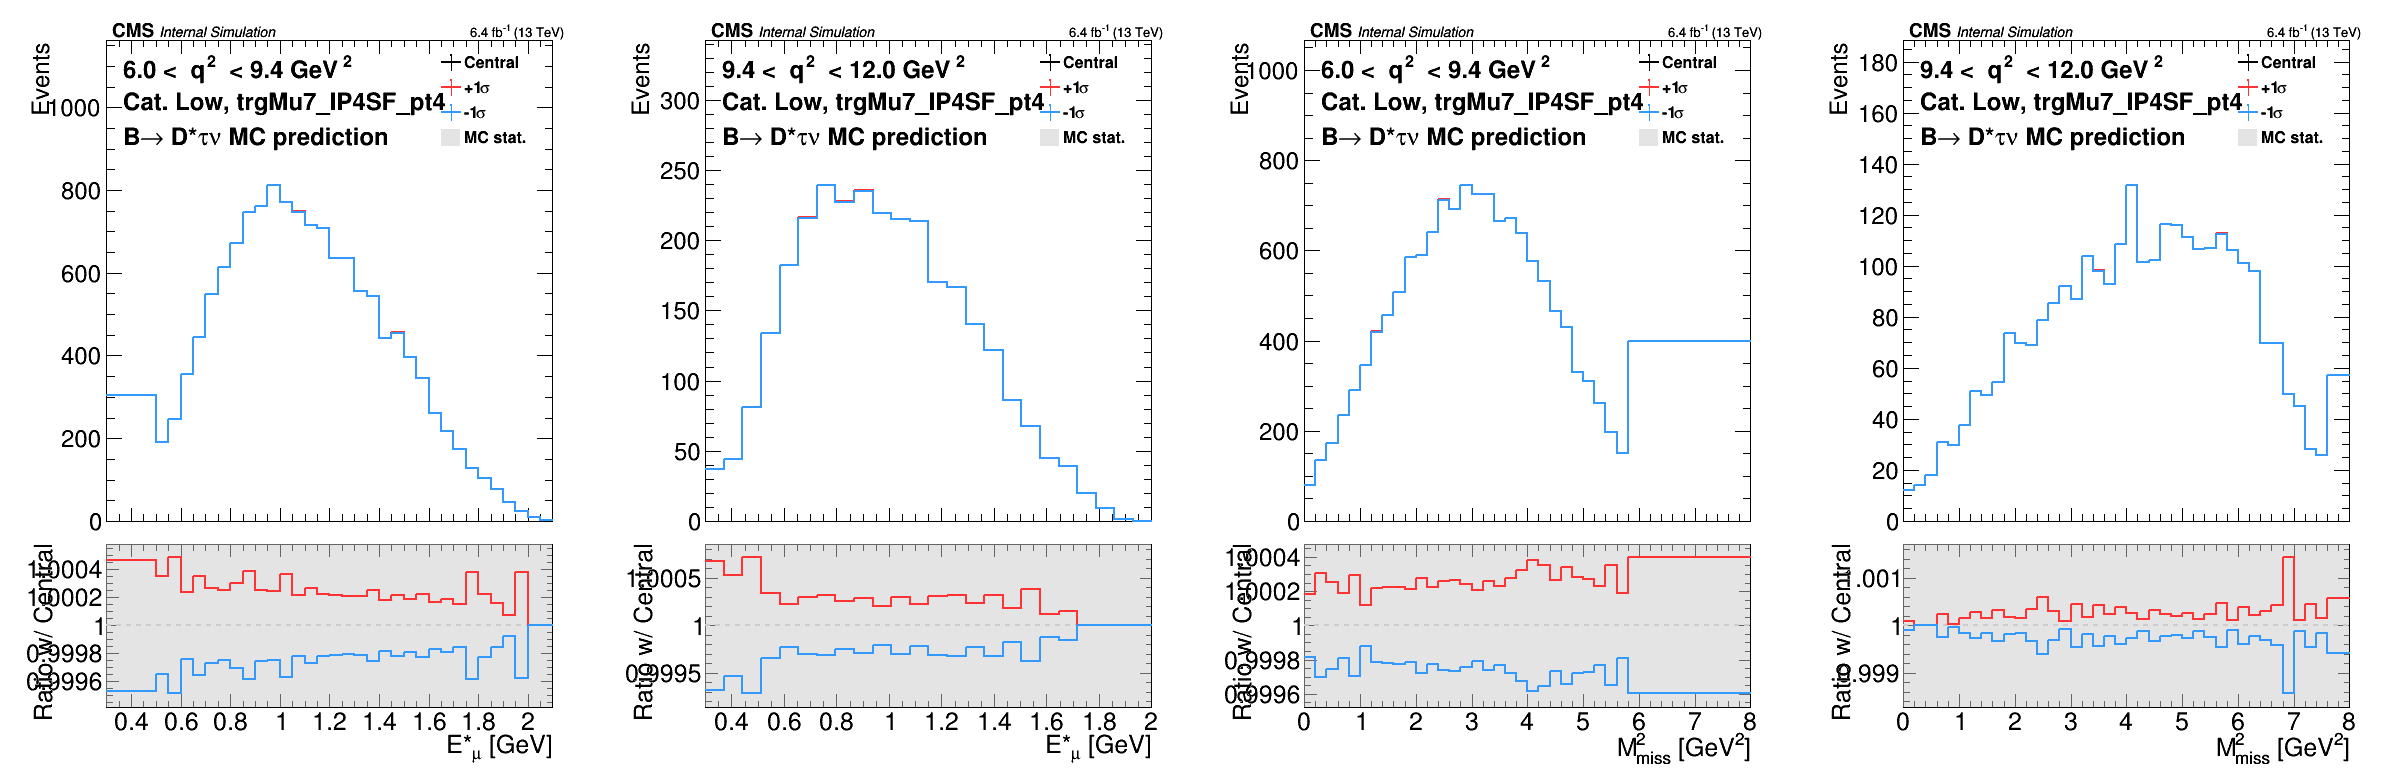

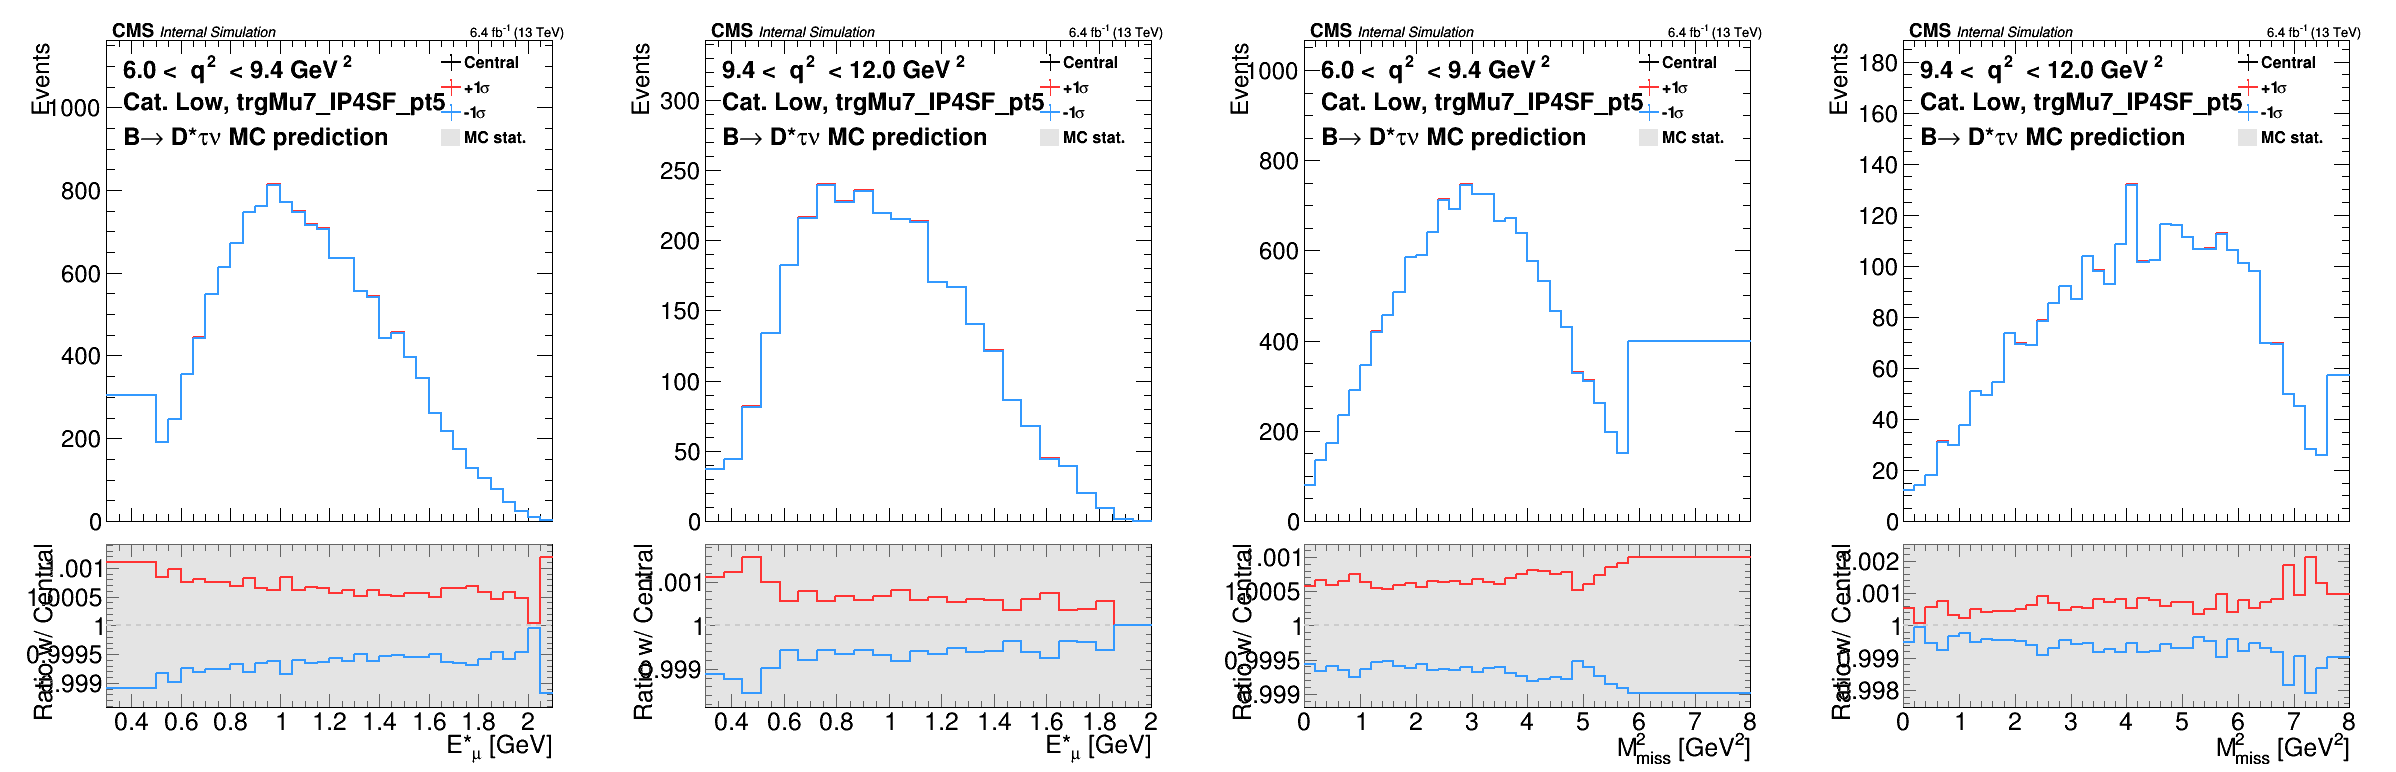

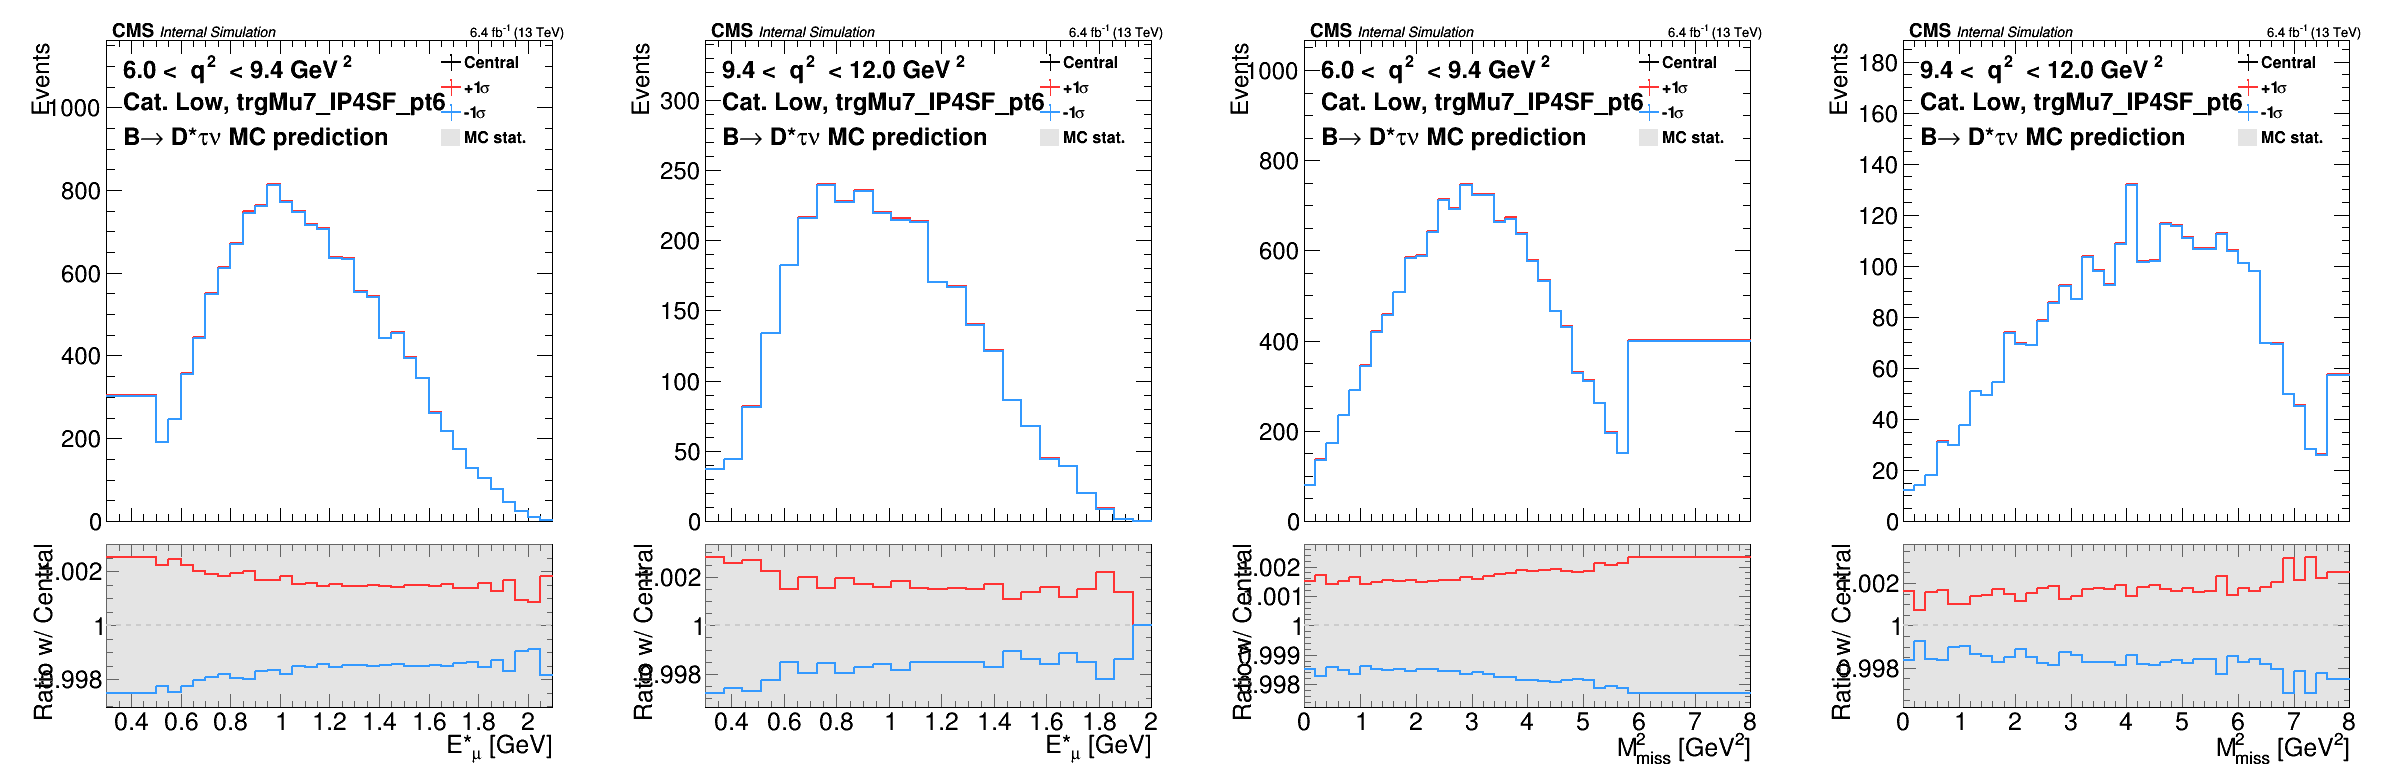

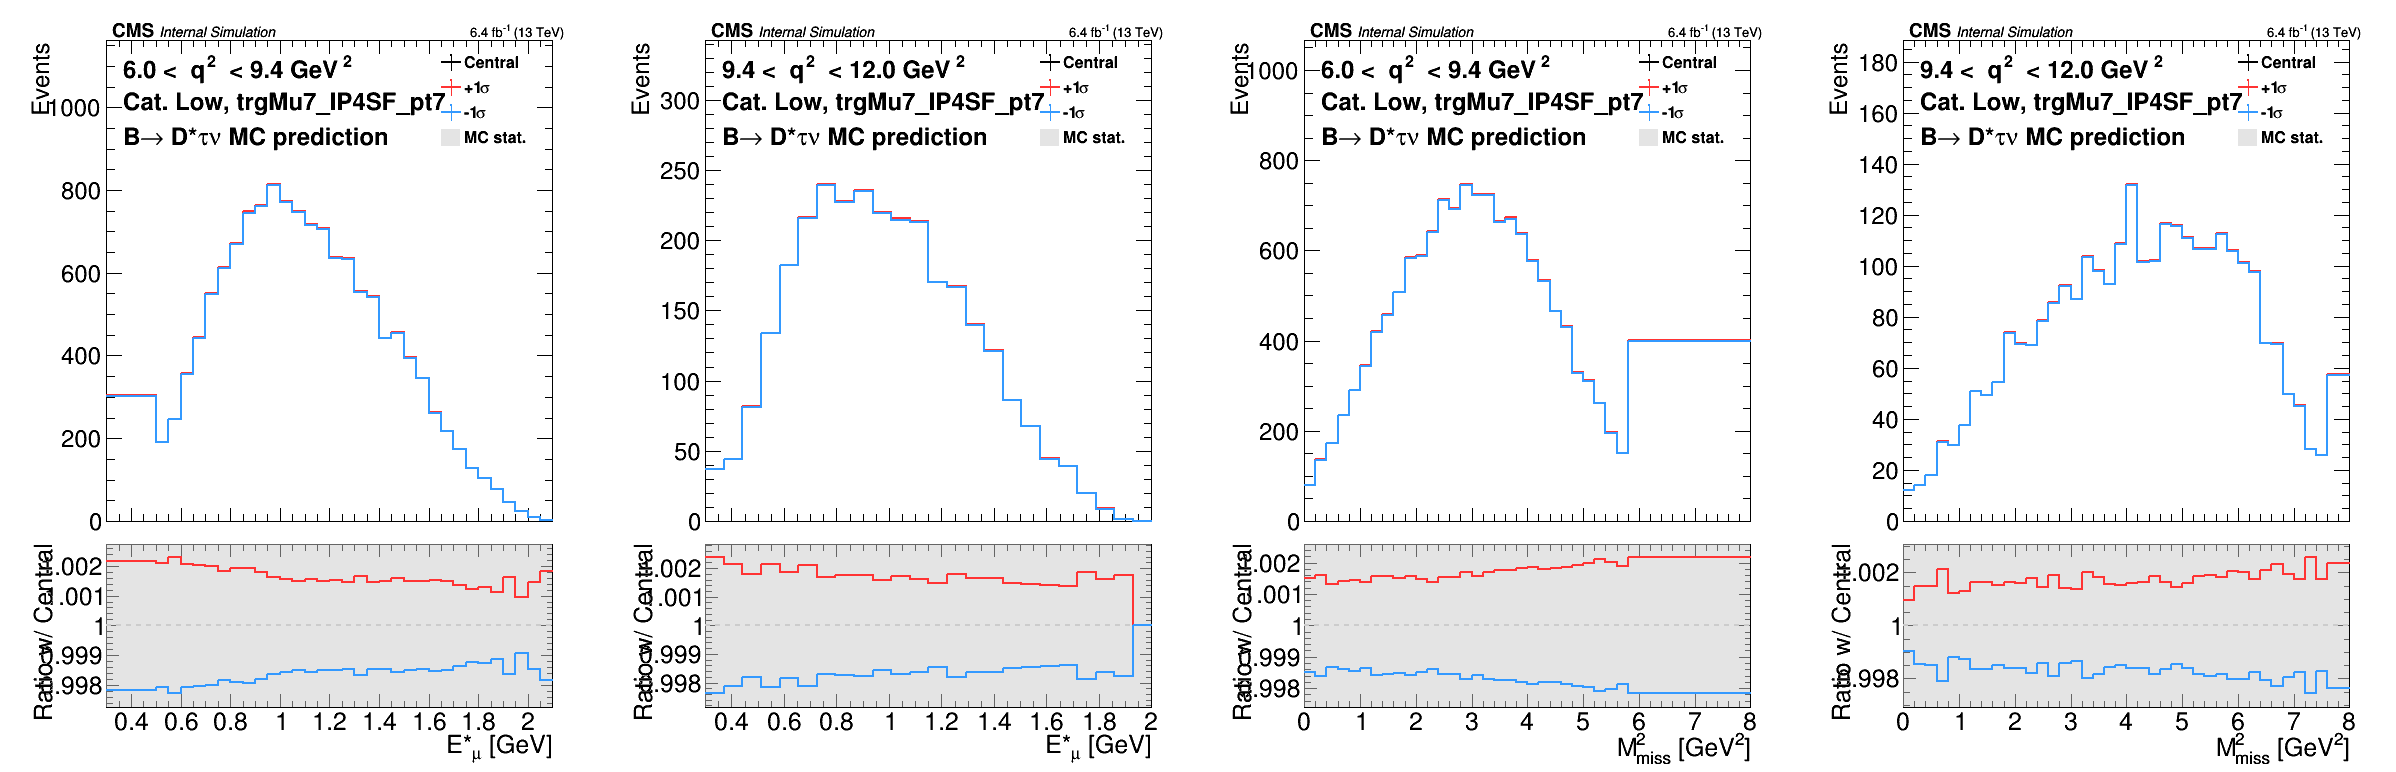

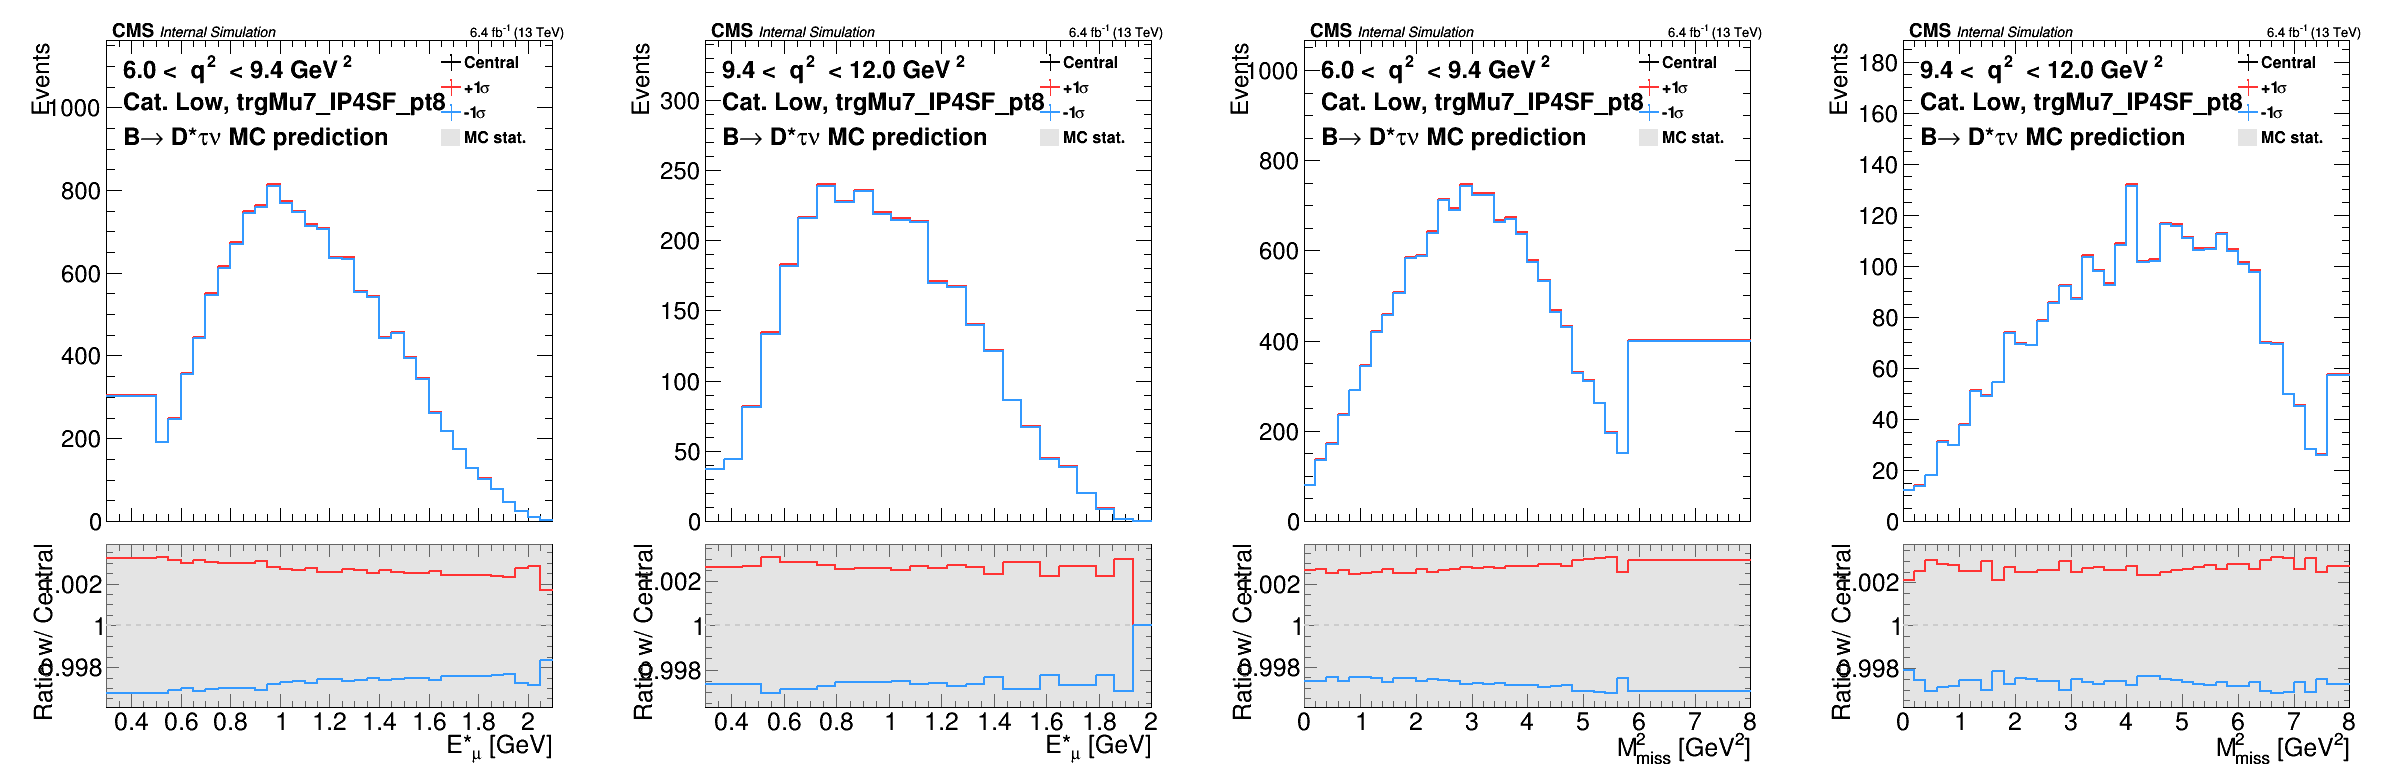

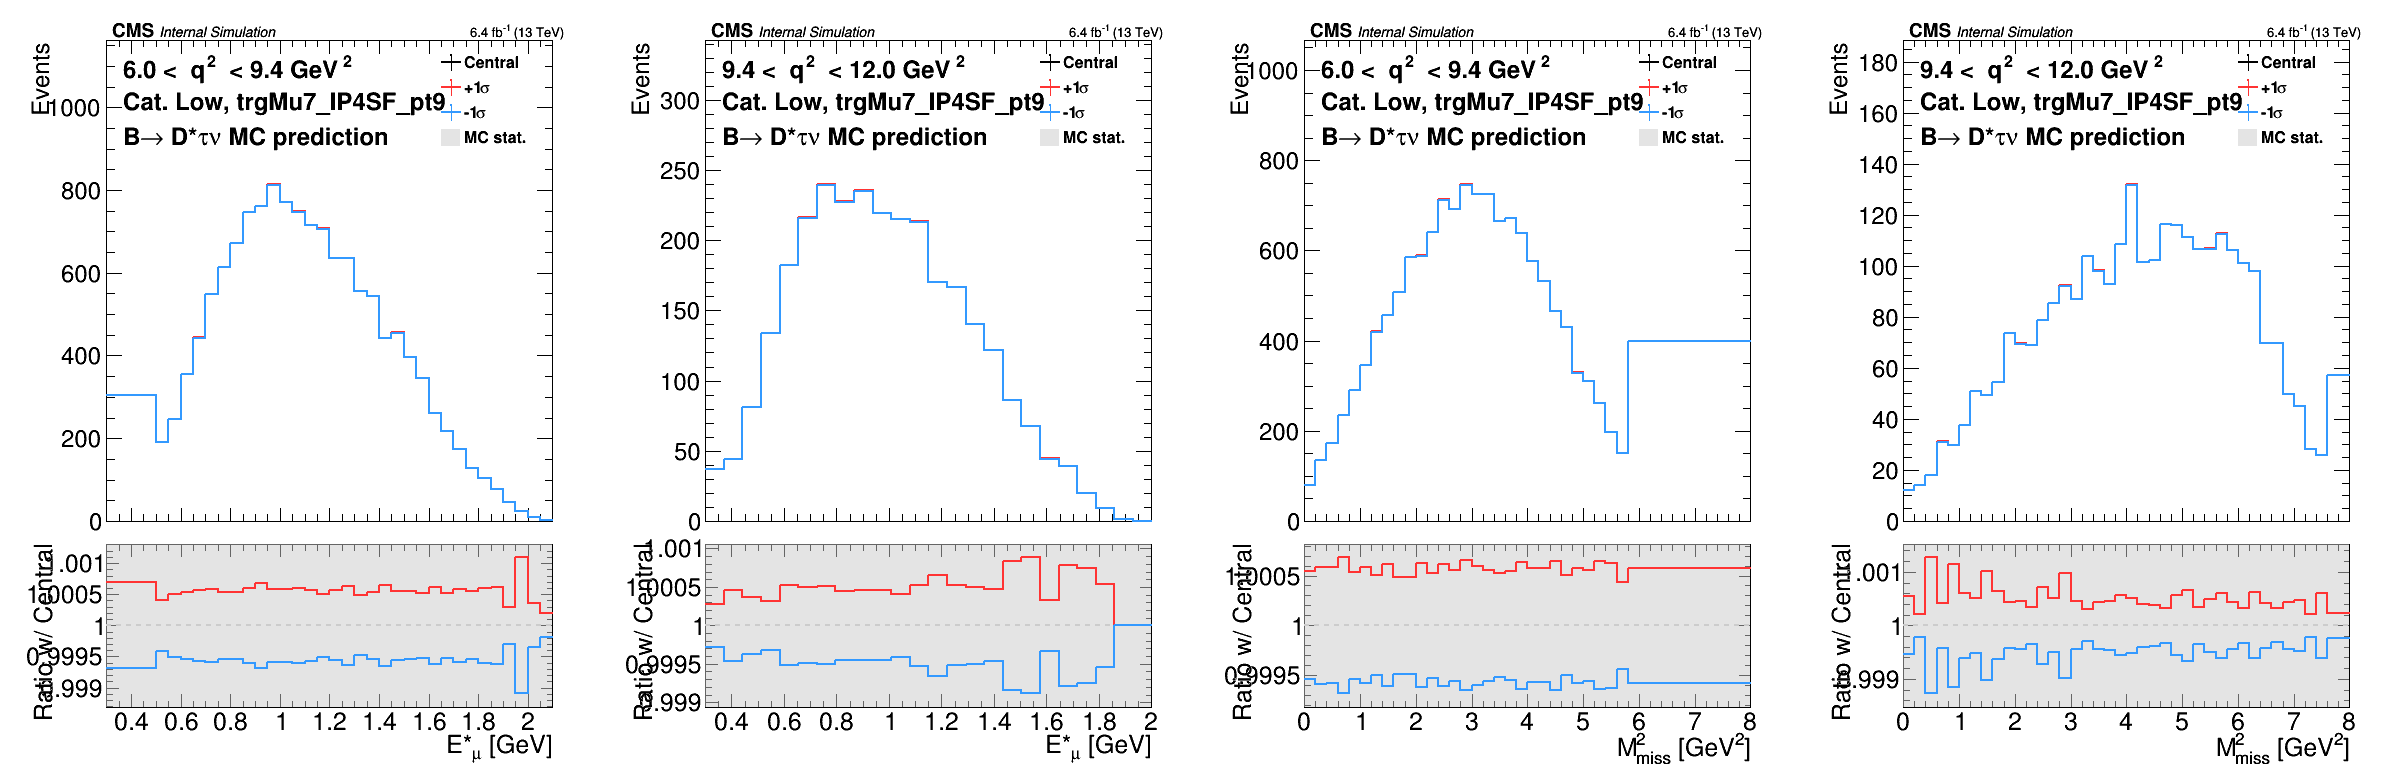

In [16]:
dndM = []
for var in variationsList:
    hUp = getVarHistos(var+'Up')
    hDown = getVarHistos(var+'Down')

    c_out = rt.TCanvas('cOut_'+var, 'cOut_'+var, len((fileH.keys()))*600, 800)
    c_out.Divide(len((fileH.keys())))
    dnd = []

    for ik, kk in enumerate(np.sort(fileH.keys())):
        pad = c_out.cd(ik+1)

        hUp[kk].SetLineColor(rt.kRed-4)
        hUp[kk].SetTitle('+1#sigma')
        hDown[kk].SetLineColor(rt.kAzure+1)
        hDown[kk].SetTitle('-1#sigma')
        for i in range(1, hCentral[kk].GetNbinsX()+1):
            if hCentral[kk].GetBinContent(i) == 0:
                hCentral[kk].SetBinContent(i, 1e-6)
                hCentral[kk].SetBinError(i, 1e-6)
            if hUp[kk].GetBinContent(i) == 0:
                hUp[kk].SetBinContent(i, 1e-6)
            if hDown[kk].GetBinContent(i) == 0:
                hDown[kk].SetBinContent(i, 1e-6)
        hl = [hCentral[kk], hUp[kk], hDown[kk]]
        for h in hl:
            h.Sumw2(0)
            h.SetMarkerStyle(2)
            h.SetMarkerSize(2)
            h.SetMarkerColor(h.GetLineColor())
        c = make_ratio_plot(hl, 
                            draw_opt='',
                            in_pad = pad,
                            leg_pos=[0.75,0.73,0.95,0.92],
                            marginTop=0.062,
                            label = var+kk,
                            ratio_bounds='auto')
        
        # Drowing MC uncertianty
        h_tot = hCentral[kk]
        g_up = rt.TGraph()
        g_up.SetPoint(0, h_tot.GetBinCenter(1)-0.5*h_tot.GetBinWidth(1), 1)
        g_down = rt.TGraph()
        g_down.SetPoint(0, h_tot.GetBinCenter(1)-0.5*h_tot.GetBinWidth(1), 1)
        for i in range(1, h_tot.GetNbinsX()+1):
            x_low = h_tot.GetBinCenter(i) - 0.5*h_tot.GetBinWidth(i)
            x_up = h_tot.GetBinCenter(i) + 0.5*h_tot.GetBinWidth(i)
            c_MC = h_tot.GetBinContent(i)
            e_MC = h_tot.GetBinError(i)
            if c_MC > 0:
                y_up = (c_MC+e_MC)/c_MC
                y_down = (c_MC-e_MC)/c_MC
            else:
                y_up = 1.
                y_down = 1.
            g_up.SetPoint(2*i-1, x_low, y_up)
            g_up.SetPoint(2*i, x_up, y_up)
            g_down.SetPoint(2*i-1, x_low, y_down)
            g_down.SetPoint(2*i, x_up, y_down)
        g_up.SetPoint(2*i+1, x_up, 1)
        g_down.SetPoint(2*i+1, x_up, 1)
        g_up.SetFillColorAlpha(rt.kGray, 0.5)
        g_up.SetFillStyle(1)
        g_down.SetFillColorAlpha(rt.kGray, 0.5)
        g_down.SetFillStyle(1)
        g_up.SetLineWidth(0)
        c.leg.AddEntry(g_up, 'MC stat.', 'f')
        c.statMCratio = [g_up, g_down]
        
        c.cd(2)
        g_up.Draw('F')
        g_down.Draw('F')
        c.ln.DrawLine(h.GetXaxis().GetXmin(), 1, h.GetXaxis().GetXmax(), 1)
        for h in c.hratio_list:
            h.Draw('same')
        
        
        #DEBUG#############
#         print var, kk
#         for i in range(1, hUp[kk].GetNbinsX()+1):
#             print '{}: {:.3f} {:1.3f} {:1.3f}'.format(i, hCentral[kk].GetBinContent(i), hUp[kk].GetBinContent(i), hDown[kk].GetBinContent(i))
#         raise
        ###################

        txt = rt.TLatex()
        txt.SetTextSize(0.05)
        txt.SetTextAlign(13)
        idx = int(kk[-1])
        q2_txt = '{:.1f} <  q^{{2}}  < {:.1f} GeV^{{2}}'.format(q2binning[idx], q2binning[idx+1])
        cat_txt = 'Cat. ' + category.capitalize() + ', ' + var
        c.pad1.cd()
        txt.DrawLatexNDC(0.18, 0.91, '#splitline{'+q2_txt+'}{'+cat_txt+'}')
        
        procLine = 'Total MC prediction'
        if not processToPlot == 'tot':
            procLine = label_dic[processToPlot] + ' MC prediction'
        txt.DrawLatexNDC(0.18, 0.775, procLine)
        CMS_lumi.CMS_lumi(c, -1, 0)

        c.Draw()
        dnd.append(c)

    c_out.Draw()
    c_out.SaveAs(outdir+'/'+var+'.png')
    c_out.SaveAs(webDir+'/'+var+'.png')
    dndM.append([c_out, dnd])